<a href="https://colab.research.google.com/github/harrybirdnz/ZZSC9020-Group_F/blob/main/individual/cameron/LSTM-sum_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv
from google.colab import drive

drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/secrets/.env'
if os.path.exists(env_path):
    token = os.getenv('GITHUB_TOKEN')
    load_dotenv(env_path)
    print("Secrets loaded from .env")
else:
    print(".env file not found at:", env_path)

REPO_NAME = 'ZZSC9020-Group_F'
repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
REPO_PATH = f"/content/{REPO_NAME}"
NOTEBOOK_SUBDIR = 'individual/cameron'

if not os.path.exists(REPO_PATH):
    print(f"Cloning repo: {REPO_NAME}")
    !git clone {REPO_URL}
else:
    print(f"Repo already exists at: {REPO_PATH}")
    os.chdir(REPO_PATH)
    print("Pulling changes from repo...")
    !git pull


target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Target notebook path not found: {target_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Secrets loaded from .env
Cloning repo: ZZSC9020-Group_F
Cloning into 'ZZSC9020-Group_F'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 384 (delta 100), reused 179 (delta 39), pack-reused 80 (from 1)
Receiving objects: 100% (384/384), 250.85 MiB | 24.01 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Updating files: 100% (59/59), done.
Working directory set to: /content/ZZSC9020-Group_F/individual/cameron


### Imports ###

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import optuna

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.saving import register_keras_serializable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

es1 = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

es2 = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

es3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [5]:
test_df = pd.read_csv('../../data/processed/processed2.csv')
test_df.head()

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0  2016-01-01          1          0          0          0          0   
1  2016-01-02          1          0          0          0          0   
2  2016-01-03          1          0          0          0          1   
3  2016-01-04          1          0          0          0          0   
4  2016-01-05          1          0          0          0          0   

   is_monday  is_tuesday  is_wednesday  is_thursday  ...  max_30_min_demand  \
0          0           0             0            0  ...            7913.75   
1          0           0             0            0  ...            7390.04   
2          0           0             0            0  ...            7328.39   
3          1           0             0            0  ...            8313.11   
4          0           1             0            0  ...            8338.82   

   sum_30_min_demand  count_30_min_points   avg_temp  min_temp  max_temp  \
0          329352.88                   48  20.704082      15.2      26.0   
1          323133.95                   48  20.572917      14.9      24.2   
2          317665.92                   48  21.130769      19.0      22.9   
3          353210.40                   48  20.144444      18.4      23.1   
4          358082.97                   48  18.904808      17.4      20.3   

   hd_next_24h  cd_next_24h  precipitation  sunlight  
0          0.0     1.204082       2.140095      32.3  
1          0.0     1.072917       6.496326      23.2  
2          0.0     1.630769       8.562486      12.7  
3          0.0     0.644444       4.082204       7.6  
4          0.0     0.000000       9.977372       3.9  

[5 rows x 38 columns]

In [6]:
test_df

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0     2016-01-01          1          0          0          0          0   
1     2016-01-02          1          0          0          0          0   
2     2016-01-03          1          0          0          0          1   
3     2016-01-04          1          0          0          0          0   
4     2016-01-05          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
1456  2019-12-27          1          0          0          0          0   
1457  2019-12-28          1          0          0          0          0   
1458  2019-12-29          1          0          0          0          1   
1459  2019-12-30          1          0          0          0          0   
1460  2019-12-31          1          0          0          0          0   

      is_monday  is_tuesday  is_wednesday  is_thursday  ...  \
0             0           0             0            0  ...   
1             0           0             0            0  ...   
2             0           0             0            0  ...   
3             1           0             0            0  ...   
4             0           1             0            0  ...   
...         ...         ...           ...          ...  ...   
1456          0           0             0            0  ...   
1457          0           0             0            0  ...   
1458          0           0             0            0  ...   
1459          1           0             0            0  ...   
1460          0           1             0            0  ...   

      max_30_min_demand  sum_30_min_demand  count_30_min_points   avg_temp  \
0               7913.75          329352.88                   48  20.704082   
1               7390.04          323133.95                   48  20.572917   
2               7328.39          317665.92                   48  21.130769   
3               8313.11          353210.40                   48  20.144444   
4               8338.82          358082.97                   48  18.904808   
...                 ...                ...                  ...        ...   
1456            9324.59          360393.59                   48  23.654717   
1457            9806.43          369325.03                   48  24.309615   
1458            9773.20          371819.56                   48  23.689583   
1459           10848.99          399427.25                   48  24.172917   
1460           11638.99          408178.89                   48  26.305882   

      min_temp  max_temp  hd_next_24h  cd_next_24h  precipitation  sunlight  
0         15.2      26.0          0.0     1.204082       2.140095      32.3  
1         14.9      24.2          0.0     1.072917       6.496326      23.2  
2         19.0      22.9          0.0     1.630769       8.562486      12.7  
3         18.4      23.1          0.0     0.644444       4.082204       7.6  
4         17.4      20.3          0.0     0.000000       9.977372       3.9  
...        ...       ...          ...          ...            ...       ...  
1456      19.2      28.5          0.0     4.154717       0.081469      30.7  
1457      16.6      29.9          0.0     4.809615       0.571150      30.8  
1458      18.1      29.3          0.0     4.189583       0.101862      21.8  
1459      18.1      31.0          0.0     4.672917       0.243804      26.3  
1460      17.7      42.1          0.0     6.805882       1.126134      27.7  

[1461 rows x 38 columns]

In [7]:
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%Y-%m-%d')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

is_summer  is_autumn  is_winter  is_spring  is_sunday  is_monday  \
datetime_au                                                                     
2016-01-01           1          0          0          0          0          0   
2016-01-02           1          0          0          0          0          0   
2016-01-03           1          0          0          0          1          0   
2016-01-04           1          0          0          0          0          1   
2016-01-05           1          0          0          0          0          0   
2016-01-06           1          0          0          0          0          0   
2016-01-07           1          0          0          0          0          0   
2016-01-08           1          0          0          0          0          0   
2016-01-09           1          0          0          0          0          0   
2016-01-10           1          0          0          0          1          0   
2016-01-11           1          0          0          0          0          1   
2016-01-12           1          0          0          0          0          0   
2016-01-13           1          0          0          0          0          0   
2016-01-14           1          0          0          0          0          0   
2016-01-15           1          0          0          0          0          0   
2016-01-16           1          0          0          0          0          0   
2016-01-17           1          0          0          0          1          0   
2016-01-18           1          0          0          0          0          1   
2016-01-19           1          0          0          0          0          0   
2016-01-20           1          0          0          0          0          0   
2016-01-21           1          0          0          0          0          0   
2016-01-22           1          0          0          0          0          0   
2016-01-23           1          0          0          0          0          0   
2016-01-24           1          0          0          0          1          0   
2016-01-25           1          0          0          0          0          1   
2016-01-26           1          0          0          0          0          0   

             is_tuesday  is_wednesday  is_thursday  is_friday  ...  \
datetime_au                                                    ...   
2016-01-01            0             0            0          1  ...   
2016-01-02            0             0            0          0  ...   
2016-01-03            0             0            0          0  ...   
2016-01-04            0             0            0          0  ...   
2016-01-05            1             0            0          0  ...   
2016-01-06            0             1            0          0  ...   
2016-01-07            0             0            1          0  ...   
2016-01-08            0             0            0          1  ...   
2016-01-09            0             0            0          0  ...   
2016-01-10            0             0            0          0  ...   
2016-01-11            0             0            0          0  ...   
2016-01-12            1             0            0          0  ...   
2016-01-13            0             1            0          0  ...   
2016-01-14            0             0            1          0  ...   
2016-01-15            0             0            0          1  ...   
2016-01-16            0             0            0          0  ...   
2016-01-17            0             0            0          0  ...   
2016-01-18            0             0            0          0  ...   
2016-01-19            1             0            0          0  ...   
2016-01-20            0             1            0          0  ...   
2016-01-21            0             0            1          0  ...   
2016-01-22            0             0            0          1  ...   
2016-01-23            0             0            0          0  .

In [8]:
print(test_df.columns)

Index(['is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday',
       'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar',
       'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct',
       'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand',
       'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points',
       'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h',
       'precipitation', 'sunlight'],
      dtype='object')


## Helper Functions ##

In [10]:
class TimeSeriesPreprocessorTVT:
    def __init__(self, df, window_size=7, allow_overlap=False):
        self.df = df.copy()
        self.window_size = window_size
        self.allow_overlap = allow_overlap
        self.scaler = MinMaxScaler()
        self.splits = {}

    def _get_year_slice(self, year):
        return self.df[self.df.index.year == year].copy()

    def _get_extended_slice(self, current_year, prior_year):
        prior_tail = self.df[
            (self.df.index.year == prior_year) &
            (self.df.index >= f"{prior_year}-12-{31 - self.window_size + 1}")
        ]
        current_full = self._get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    def split(self):
        years = sorted(self.df.index.year.unique())
        if self.allow_overlap:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_extended_slice(years[2], years[1])
            test_df = self._get_extended_slice(years[3], years[2])
        else:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_year_slice(years[2])
            test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['val_raw'] = val_df
        self.splits['test_raw'] = test_df

    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'val_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    def to_X_and_y(self, df_scaled, target_col='sum_30_min_demand'):
        target_index = df_scaled.columns.get_loc(target_col)
        df_np = df_scaled.to_numpy()
        X, y = [], []
        for i in range(len(df_np) - self.window_size):
            X.append(df_np[i:i+self.window_size, :])
            y.append(df_np[i+self.window_size, target_index])
        return np.array(X), np.array(y)

    def get_model_inputs(self, target_col='sum_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'val_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs
class TimeSeriesPreprocessorTT(TimeSeriesPreprocessorTVT):
    def split(self):
        years = sorted(self.df.index.year.unique())

        # Extend training to 3 years
        train_df = pd.concat([
            self._get_year_slice(years[0]),
            self._get_year_slice(years[1]),
            self._get_year_slice(years[2])
        ])

        # Test set is the final year
        test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['test_raw'] = test_df
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'test_raw']:  # No 'val_raw' in this subclass
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled
    def get_model_inputs(self, target_col='sum_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'test_scaled']:  # No val_scaled here
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs


### Setup function for printing, metrics ###

In [11]:
## Optuna Function
def objective(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train20.shape[1], X_train20.shape[2])),
            layers.LSTM(n_units, dropout=dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train20, y_train20, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

In [12]:
## Tweaked Optuna function for early stopping, etc.

def objective2(trial):
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    n_units1 = trial.suggest_int("n_units1", 32, 128)
    n_units2 = trial.suggest_int("n_units2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    stacked = trial.suggest_categorical("stacked", [False, True])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        if stacked:
            model.add(LSTM(n_units1, return_sequences=True, dropout=dropout))
            model.add(LSTM(n_units2, dropout=dropout))
        else:
            model.add(LSTM(n_units1, dropout=dropout))

        model.add(Dense(8, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        checkpoint_path = f"trial_{trial.number}_best.keras"
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                            save_best_only=True, save_weights_only=False, verbose=0)
        ]

        history = model.fit(
            X_train20, y_train20,
            epochs=200,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            callbacks=callbacks,
            verbose=0
        )

        best_model = load_model(checkpoint_path)

        y_pred = best_model.predict(X_test20, verbose=0)

        # Inverse transform
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: stacked={stacked}, units1={n_units1}, units2={n_units2}, "
          f"dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae

In [13]:
## Optuna Function for CNN=LSTM Hybrid ##

def objective3(trial):
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    filters = trial.suggest_int("filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    pool_size = trial.suggest_int("pool_size", 2, 3)
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        # CNN block
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(dropout))

        # LSTM block
        model.add(LSTM(lstm_units, dropout=0.013))

        # Dense head
        model.add(Dense(16, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        # Train with validation split for val_loss
        model.fit(
            X_train20, y_train20,
            epochs=100,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            verbose=0
        )

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: filters={filters}, kernel={kernel_size}, pool={pool_size}, "
          f"lstm_units={lstm_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae


In [14]:
## Final Optuna Function - include Recurrent Dropout

def objective4(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.3)

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train29.shape[1], X_train29.shape[2])),
            layers.LSTM(n_units, dropout=dropout, recurrent_dropout=recurrent_dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train29, y_train29, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test29, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

## 1. Base Model - Avg Demand Only ##

In [15]:
demandDF = test_df[['sum_30_min_demand']]

In [16]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

i = X_train.shape[1]
j = X_train.shape[2]

In [17]:
def predictions_plot(model, X, y_scaled, start = 0, end = 100, processor=preprocessor, target_col='sum_30_min_demand'):
    y_pred_scaled = model.predict(X)

    # Get column index for inverse transform
    target_index = processor.splits['train_raw'].columns.get_loc(target_col)

    # Inverse transform using full column count
    y_orig = processor.scaler.inverse_transform(
        np.pad(y_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    y_pred_orig = processor.scaler.inverse_transform(
        np.pad(y_pred_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    # Plot
    results = pd.DataFrame({'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')
    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

In [18]:
model1 = Sequential()
model1.add(InputLayer((i, j)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1047 - mean_absolute_percentage_error: 204353.8438 - root_mean_squared_error: 0.3165 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 49.4024 - val_root_mean_squared_error: 0.1468
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0214 - mean_absolute_percentage_error: 400751.2500 - root_mean_squared_error: 0.1464 - val_loss: 0.0128 - val_mean_absolute_percentage_error: 33.3195 - val_root_mean_squared_error: 0.1130
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0172 - mean_absolute_percentage_error: 414227.0625 - root_mean_squared_error: 0.1312 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 33.8775 - val_root_mean_squared_error: 0.1119
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - mean_absolute_percentage_error: 389214.2188 - root_mean_squared_error: 0.1291 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 34.3991 - val_root_mean_squared_error: 0.1118


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


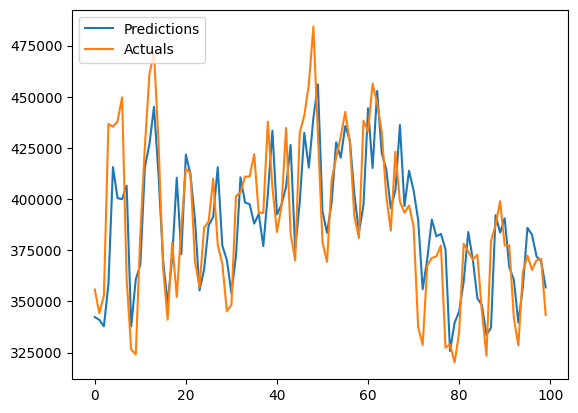

MAPE: 3.95%
RMSE: 20592.04
MAE : 15328.59


Predictions    Actuals
0    342354.71875  355814.96
1    340956.81250  344216.79
2    337807.53125  352812.68
3    358393.25000  436716.40
4    415626.75000  435360.14
..            ...        ...
719  379988.53125  353967.95
720  377911.18750  385900.00
721  393933.40625  411636.83
722  403804.56250  379656.38
723  364600.87500  342930.54

[724 rows x 2 columns]

In [20]:
model1 = load_model('model1.keras')

predictions_plot(model1, X_train, y_train, 0, 100, preprocessor)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


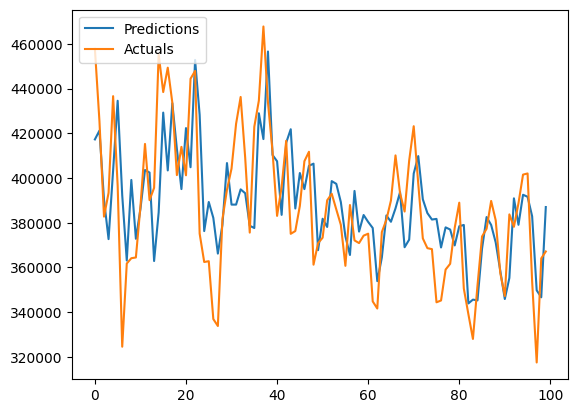

MAPE: 3.79%
RMSE: 18807.03
MAE : 14453.97


Predictions    Actuals
0    417279.75000  457780.70
1    421231.93750  425439.99
2    390353.87500  382741.80
3    372683.50000  393359.12
4    403412.21875  436628.85
..            ...        ...
353  383839.71875  405457.46
354  391220.09375  421027.63
355  378808.09375  407376.71
356  362504.46875  402263.51
357  367815.53125  405023.08

[358 rows x 2 columns]

In [21]:
predictions_plot(model1, X_val, y_val, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


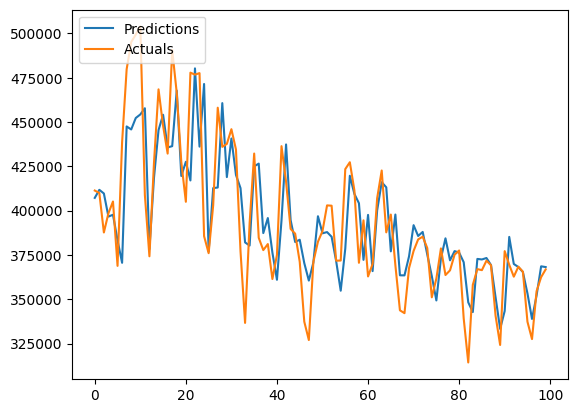

MAPE: 3.88%
RMSE: 19859.89
MAE : 14821.13


Predictions    Actuals
0    407195.06250  411339.27
1    411747.46875  409963.40
2    409680.75000  387672.63
3    396644.59375  398542.65
4    397675.62500  405159.36
..            ...        ...
353  367882.28125  360393.59
354  373286.96875  369325.03
355  359579.93750  371819.56
356  364303.62500  399427.25
357  378167.62500  408178.89

[358 rows x 2 columns]

In [22]:
predictions_plot(model1, X_test, y_test, 0, 100)

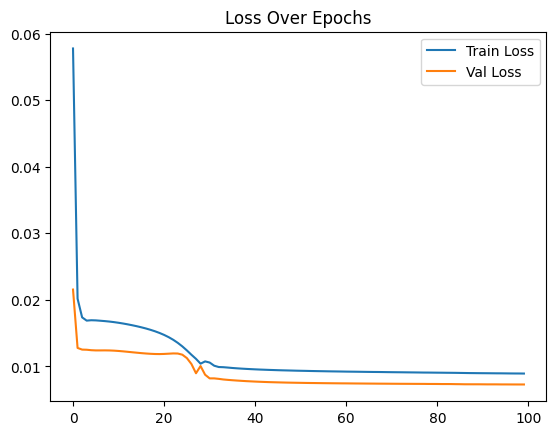

In [23]:
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 2 - Overlapping Windows ###

In [24]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=True)
preprocessor.split()
preprocessor.scale()
data2 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train2, y_train2 = data2['train']
X_val2, y_val2 = data2['val']
X_test2, y_test2 = data2['test']

i = X_train2.shape[1]
j = X_train2.shape[2]

In [25]:
model2 = Sequential()
model2.add(InputLayer((i, j)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
cp2 = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1516 - root_mean_squared_error: 0.3879 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1929
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0280 - root_mean_squared_error: 0.1664 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0179 - root_mean_squared_error: 0.1338 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1186
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0180 - root_mean_squared_error: 0.1340 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


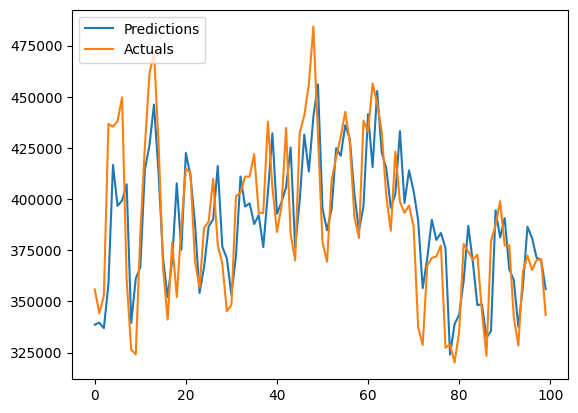

MAPE: 3.94%
RMSE: 20656.20
MAE : 15290.31


Predictions    Actuals
0    338617.06250  355814.96
1    339603.75000  344216.79
2    336868.25000  352812.68
3    358394.78125  436716.40
4    416664.06250  435360.14
..            ...        ...
719  380195.81250  353967.95
720  377779.65625  385900.00
721  393717.93750  411636.83
722  404842.28125  379656.38
723  363703.18750  342930.54

[724 rows x 2 columns]

In [27]:
model2 = load_model('model2.keras')

predictions_plot(model2, X_train2, y_train2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


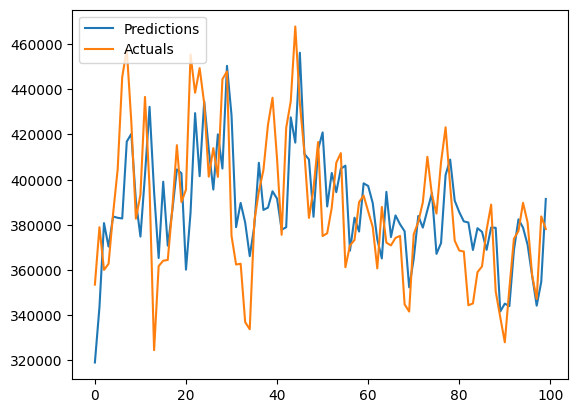

MAPE: 3.85%
RMSE: 19225.31
MAE : 14716.44


Predictions    Actuals
0    319102.15625  353567.49
1    343530.53125  378965.84
2    380785.87500  360065.93
3    370391.37500  362772.07
4    383718.90625  385022.79
..            ...        ...
360  386694.65625  405457.46
361  392277.40625  421027.63
362  368347.12500  407376.71
363  361847.75000  402263.51
364  367476.59375  405023.08

[365 rows x 2 columns]

In [28]:
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


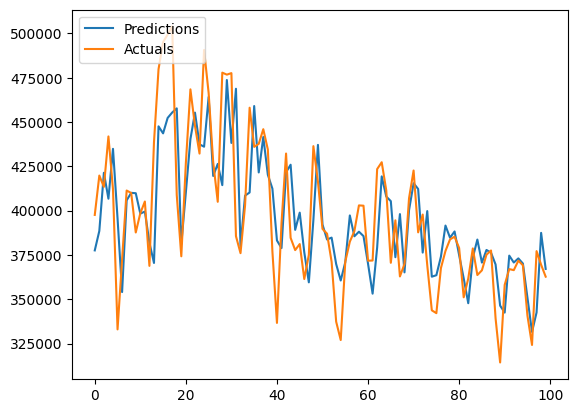

MAPE: 3.94%
RMSE: 20143.30
MAE : 15051.00


Predictions    Actuals
0    377568.96875  397576.81
1    388539.87500  419793.03
2    421342.00000  413402.43
3    406735.28125  441857.98
4    434867.71875  412076.90
..            ...        ...
360  370079.46875  360393.59
361  374712.46875  369325.03
362  357439.43750  371819.56
363  364295.28125  399427.25
364  379191.71875  408178.89

[365 rows x 2 columns]

In [29]:
predictions_plot(model2, X_test2, y_test2, 0, 100)

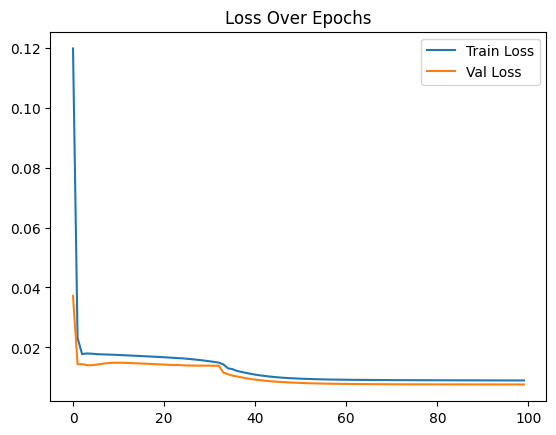

In [30]:
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 2. Introducing Temperature... ##

In [31]:
tempDemandDF = test_df[['sum_30_min_demand', 'avg_temp']]

In [32]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data3 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train3, y_train3 = data3['train']
X_val3, y_val3 = data3['val']
X_test3, y_test3 = data3['test']

i = X_train3.shape[1]
j = X_train3.shape[2]

### Model 3 ###

In [33]:
model3 = Sequential()
model3.add(InputLayer((i, j)))
model3.add(LSTM(64))
model3.add(Dense(8, 'tanh'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0722 - root_mean_squared_error: 0.2626 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1341
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - root_mean_squared_error: 0.1418 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174 - root_mean_squared_error: 0.1320 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


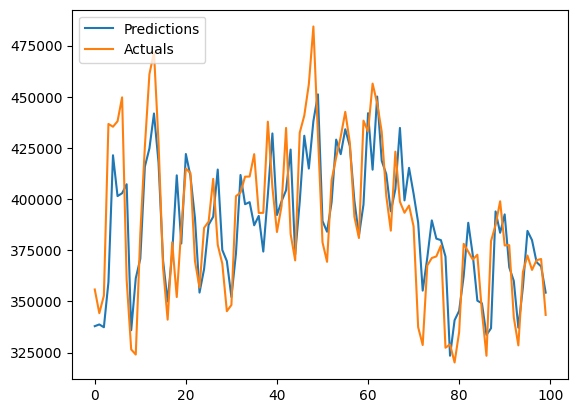

MAPE: 3.86%
RMSE: 20326.35
MAE : 14974.16


Predictions    Actuals
0    337878.21875  355814.96
1    338727.31250  344216.79
2    337353.28125  352812.68
3    359361.50000  436716.40
4    421414.43750  435360.14
..            ...        ...
719  382664.34375  353967.95
720  380525.43750  385900.00
721  398935.65625  411636.83
722  408344.62500  379656.38
723  368889.78125  342930.54

[724 rows x 2 columns]

In [35]:
model3 = load_model('model3.keras')

predictions_plot(model3, X_train3, y_train3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


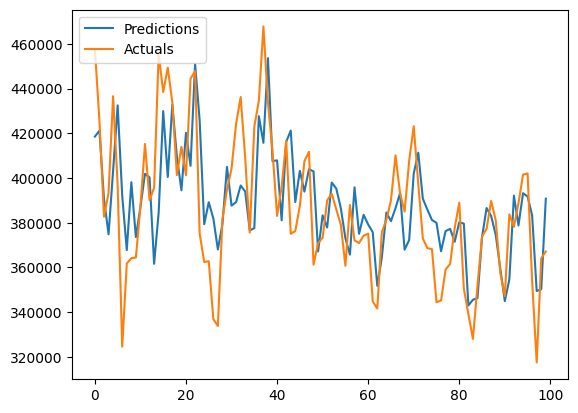

MAPE: 3.74%
RMSE: 18581.60
MAE : 14278.69


Predictions    Actuals
0    418549.75000  457780.70
1    421185.87500  425439.99
2    390565.31250  382741.80
3    374855.87500  393359.12
4    403393.87500  436628.85
..            ...        ...
353  386035.87500  405457.46
354  397083.46875  421027.63
355  386279.09375  407376.71
356  370171.09375  402263.51
357  373069.53125  405023.08

[358 rows x 2 columns]

In [36]:
predictions_plot(model3, X_val3, y_val3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


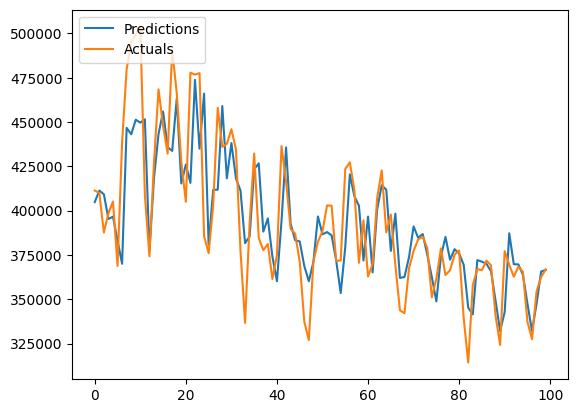

MAPE: 3.87%
RMSE: 19898.76
MAE : 14750.58


Predictions    Actuals
0    404826.12500  411339.27
1    411309.40625  409963.40
2    409234.34375  387672.63
3    395291.81250  398542.65
4    396629.56250  405159.36
..            ...        ...
353  371205.09375  360393.59
354  379358.21875  369325.03
355  370569.75000  371819.56
356  374932.43750  399427.25
357  387272.21875  408178.89

[358 rows x 2 columns]

In [37]:
predictions_plot(model3, X_test3, y_test3, 0, 100)

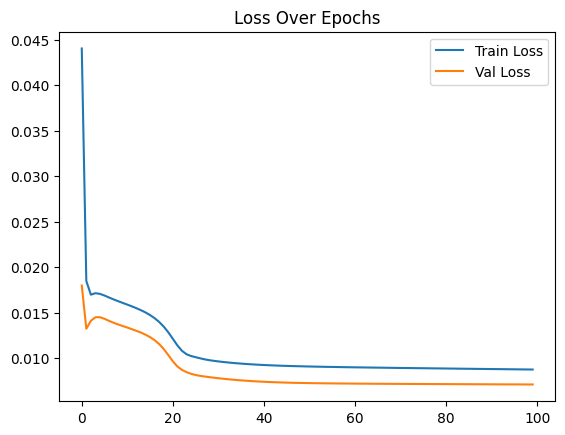

In [38]:
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Feature Analysis ##

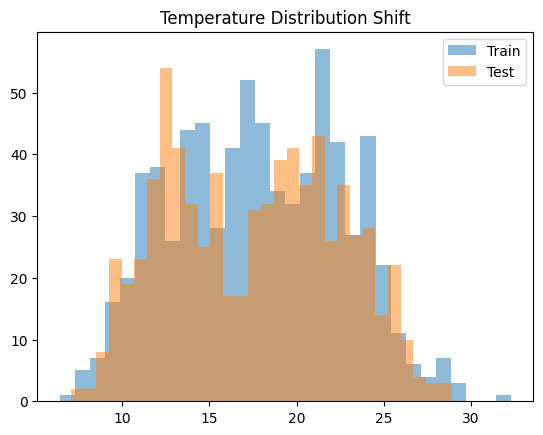

In [39]:
plt.hist(test_df['avg_temp'][0:731], bins=30, alpha=0.5, label='Train')
plt.hist(test_df['avg_temp'][732:], bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title("Temperature Distribution Shift")
plt.show()

## Testing Temp Measures ##

In [40]:
tempDemandDF2 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]

## Model 4 ##

In [41]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data4 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train4, y_train4 = data4['train']
X_val4, y_val4 = data4['val']
X_test4, y_test4 = data4['test']

i = X_train4.shape[1]
j = X_train4.shape[2]

In [42]:
model4 = Sequential()
model4.add(InputLayer((i, j)))
model4.add(LSTM(64))
model4.add(Dense(8, 'tanh'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1627 - root_mean_squared_error: 0.3918 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1554
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1270
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1208
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


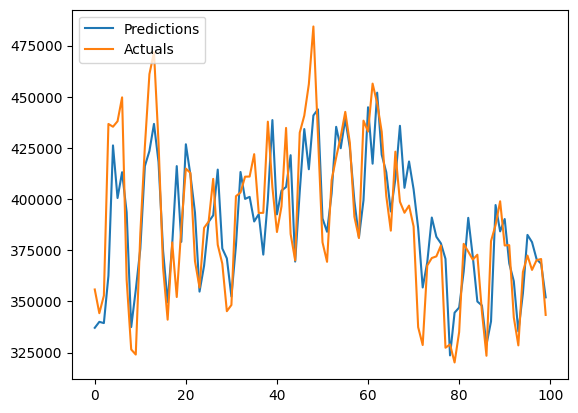

MAPE: 3.81%
RMSE: 19926.93
MAE : 14736.08


Predictions    Actuals
0    337076.93750  355814.96
1    339994.00000  344216.79
2    339386.56250  352812.68
3    362512.50000  436716.40
4    426233.68750  435360.14
..            ...        ...
719  379766.78125  353967.95
720  385572.34375  385900.00
721  398724.50000  411636.83
722  405623.93750  379656.38
723  359994.00000  342930.54

[724 rows x 2 columns]

In [44]:
model4 = load_model('model4.keras')

predictions_plot(model4, X_train4, y_train4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


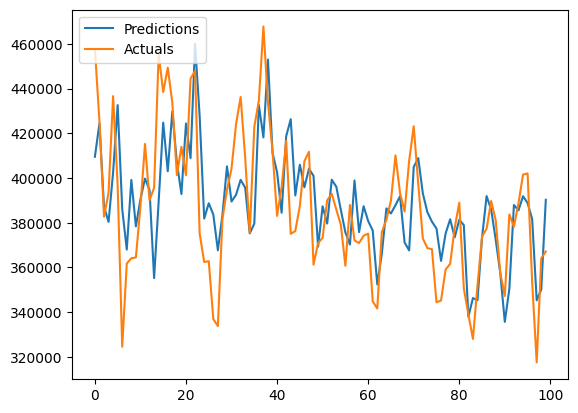

MAPE: 3.77%
RMSE: 18634.95
MAE : 14316.30


Predictions    Actuals
0    409522.56250  457780.70
1    424439.96875  425439.99
2    387217.15625  382741.80
3    380381.31250  393359.12
4    402607.84375  436628.85
..            ...        ...
353  384873.03125  405457.46
354  402023.34375  421027.63
355  396575.28125  407376.71
356  372898.96875  402263.51
357  370597.06250  405023.08

[358 rows x 2 columns]

In [45]:
predictions_plot(model4, X_val4, y_val4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


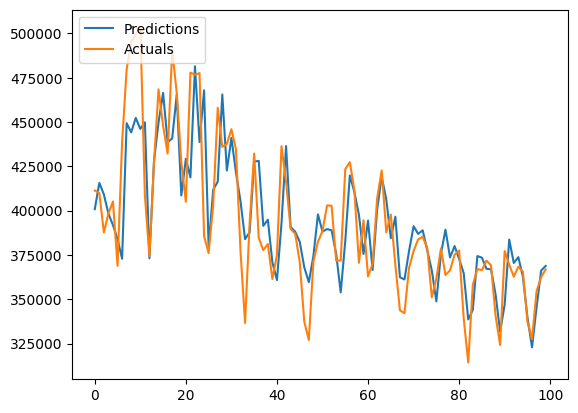

MAPE: 3.84%
RMSE: 19624.07
MAE : 14611.08


Predictions    Actuals
0    400822.25000  411339.27
1    415653.71875  409963.40
2    409136.71875  387672.63
3    398303.40625  398542.65
4    391833.84375  405159.36
..            ...        ...
353  373565.37500  360393.59
354  379121.50000  369325.03
355  374931.12500  371819.56
356  375777.46875  399427.25
357  387835.75000  408178.89

[358 rows x 2 columns]

In [46]:
predictions_plot(model4, X_test4, y_test4, 0, 100)

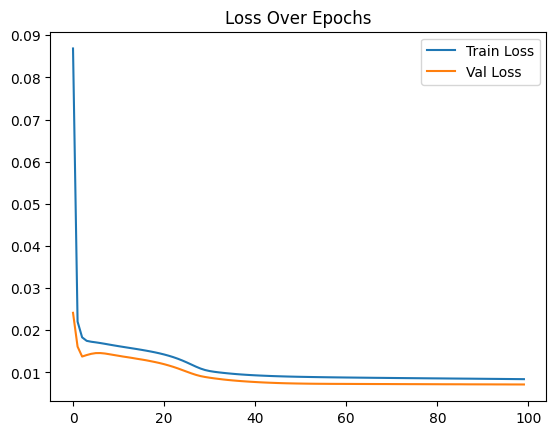

In [47]:
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 5 ##

In [48]:
test_df['temp_range'] = test_df['max_temp'] - test_df['min_temp']

tempDemandDF3 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)

In [49]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF3, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data5 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train5, y_train5 = data5['train']
X_val5, y_val5 = data5['val']
X_test5, y_test5 = data5['test']

i = X_train5.shape[1]
j = X_train5.shape[2]

In [50]:
model5 = Sequential()
model5.add(InputLayer((i, j)))
model5.add(LSTM(64))
model5.add(Dense(8, 'tanh'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history5 = model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0605 - root_mean_squared_error: 0.2403 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1220
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1380 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1125
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - root_mean_squared_error: 0.1311 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


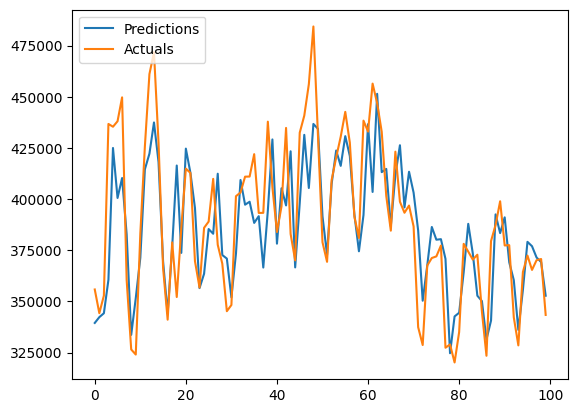

MAPE: 3.69%
RMSE: 19480.32
MAE : 14329.26


Predictions    Actuals
0    339458.93750  355814.96
1    342280.62500  344216.79
2    344191.37500  352812.68
3    360545.37500  436716.40
4    424975.78125  435360.14
..            ...        ...
719  378553.09375  353967.95
720  380364.62500  385900.00
721  399734.56250  411636.83
722  410591.06250  379656.38
723  369728.87500  342930.54

[724 rows x 2 columns]

In [52]:
model5 = load_model('model5.keras')

predictions_plot(model5, X_train5, y_train5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


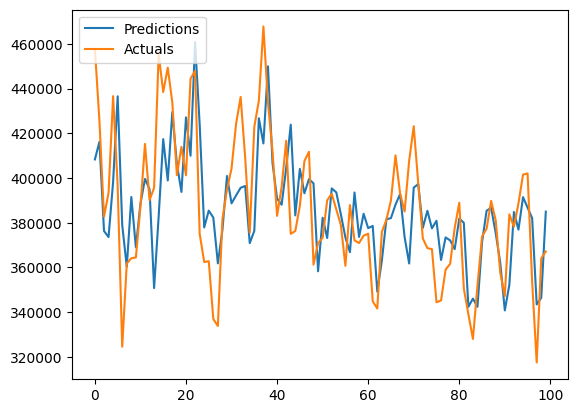

MAPE: 3.69%
RMSE: 18468.21
MAE : 14102.43


Predictions    Actuals
0    408334.65625  457780.70
1    416228.09375  425439.99
2    376314.15625  382741.80
3    373603.78125  393359.12
4    398321.50000  436628.85
..            ...        ...
353  385229.37500  405457.46
354  401122.62500  421027.63
355  392938.68750  407376.71
356  369473.62500  402263.51
357  364469.21875  405023.08

[358 rows x 2 columns]

In [53]:
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


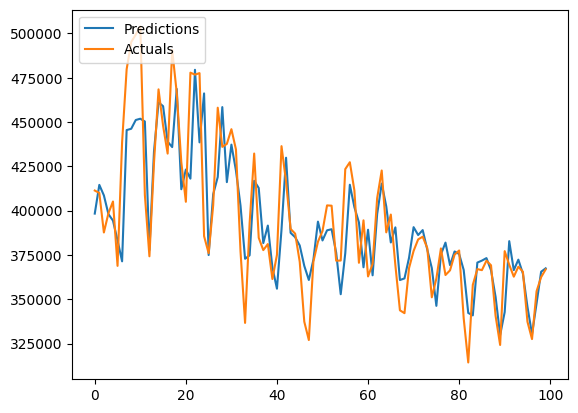

MAPE: 3.71%
RMSE: 19083.57
MAE : 14179.82


Predictions    Actuals
0    398328.15625  411339.27
1    414528.84375  409963.40
2    408611.40625  387672.63
3    398037.71875  398542.65
4    394356.25000  405159.36
..            ...        ...
353  372003.56250  360393.59
354  379662.81250  369325.03
355  374646.37500  371819.56
356  378968.18750  399427.25
357  390399.18750  408178.89

[358 rows x 2 columns]

In [54]:
predictions_plot(model5, X_test5, y_test5, 0, 100)

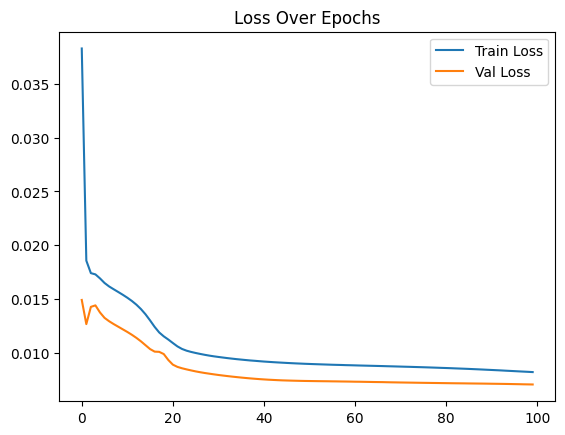

In [55]:
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 6 ##

In [56]:
tempDemandDF4 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()

In [57]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data6 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train6, y_train6 = data6['train']
X_val6, y_val6 = data6['val']
X_test6, y_test6 = data6['test']

i = X_train6.shape[1]
j = X_train6.shape[2]

In [58]:
model6 = Sequential()
model6.add(InputLayer((i, j)))
model6.add(LSTM(64))
model6.add(Dense(8, 'tanh'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history6 = model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0519 - root_mean_squared_error: 0.2237 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1220
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0197 - root_mean_squared_error: 0.1405 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1252
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - root_mean_squared_error: 0.1255 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - root_mean_squared_error: 0.1247 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


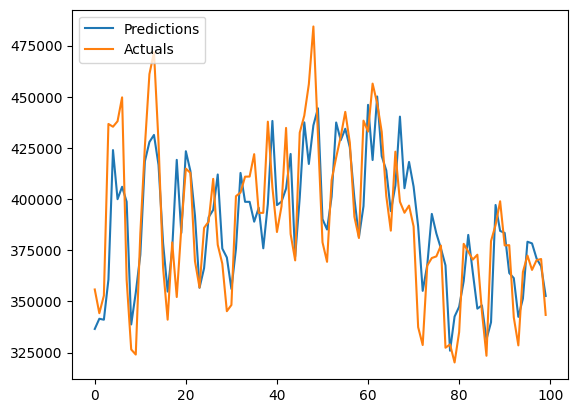

MAPE: 3.95%
RMSE: 20414.29
MAE : 15252.53


Predictions    Actuals
0    336518.84375  355814.96
1    341506.43750  344216.79
2    341034.18750  352812.68
3    360656.15625  436716.40
4    423942.65625  435360.14
..            ...        ...
719  376942.53125  353967.95
720  387215.90625  385900.00
721  393216.31250  411636.83
722  393571.87500  379656.38
723  352559.03125  342930.54

[724 rows x 2 columns]

In [60]:
model6 = load_model('model6.keras')
predictions_plot(model6, X_train6, y_train6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


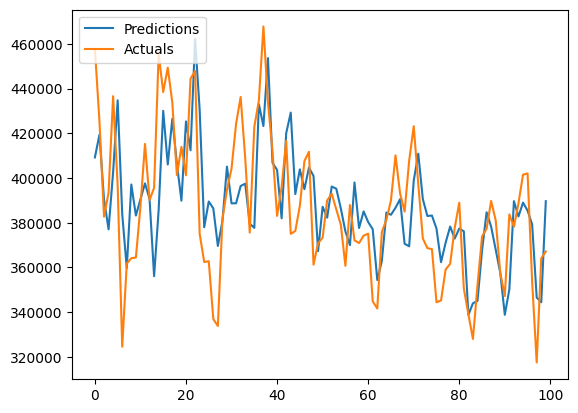

MAPE: 3.93%
RMSE: 19248.43
MAE : 14962.16


Predictions    Actuals
0    409238.15625  457780.70
1    419398.56250  425439.99
2    390519.53125  382741.80
3    377056.34375  393359.12
4    402615.40625  436628.85
..            ...        ...
353  379339.28125  405457.46
354  393895.90625  421027.63
355  385810.90625  407376.71
356  367343.53125  402263.51
357  367878.40625  405023.08

[358 rows x 2 columns]

In [61]:
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


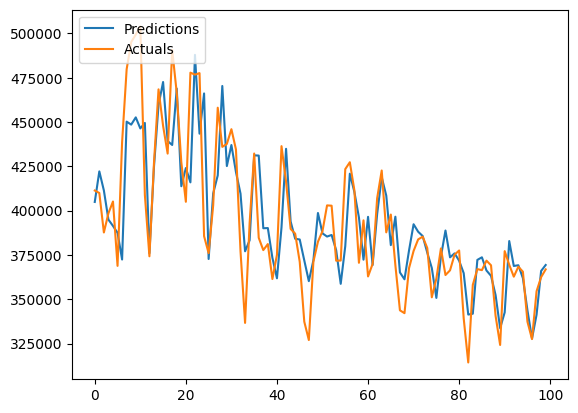

MAPE: 4.01%
RMSE: 20364.02
MAE : 15292.78


Predictions    Actuals
0    404901.56250  411339.27
1    422152.40625  409963.40
2    411375.59375  387672.63
3    394929.75000  398542.65
4    391370.00000  405159.36
..            ...        ...
353  366018.56250  360393.59
354  372245.90625  369325.03
355  365352.87500  371819.56
356  365609.18750  399427.25
357  379758.81250  408178.89

[358 rows x 2 columns]

In [62]:
predictions_plot(model6, X_test6, y_test6, 0, 100)

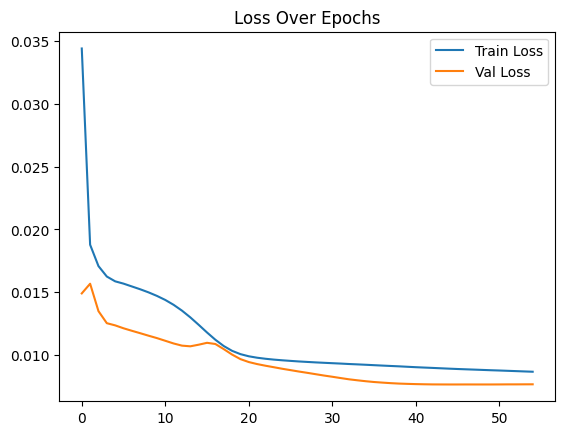

In [63]:
plt.plot(history6.history['loss'], label='Train Loss')
plt.plot(history6.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Increase Window Size to 10 ##

## Model 7 ##

In [67]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=10, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data7 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train7, y_train7 = data7['train']
X_val7, y_val7 = data7['val']
X_test7, y_test7 = data7['test']

i = X_train7.shape[1]
j = X_train7.shape[2]

In [68]:
model7 = Sequential()
model7.add(InputLayer((i, j)))
model7.add(LSTM(64))
model7.add(Dense(8, 'tanh'))
model7.add(Dense(1, 'linear'))

model7.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history7 = model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1632 - root_mean_squared_error: 0.3919 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1310
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1275
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206 - root_mean_squared_error: 0.1432 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1142
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0179 - root_mean_squared_error: 0.1336 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - root_mean_squared_error: 0.1298 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1290 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


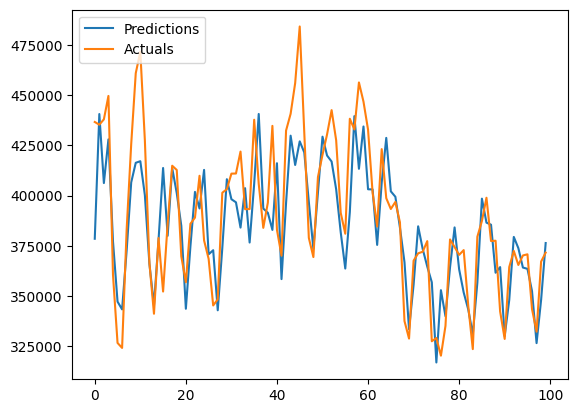

MAPE: 3.79%
RMSE: 19823.58
MAE : 14834.93


Predictions    Actuals
0    378460.15625  436716.40
1    440677.75000  435360.14
2    406242.75000  438032.58
3    428046.21875  449709.69
4    377165.62500  360495.64
..            ...        ...
716  356980.59375  353967.95
717  367994.59375  385900.00
718  381801.65625  411636.83
719  392340.34375  379656.38
720  348223.09375  342930.54

[721 rows x 2 columns]

In [70]:
model7 = load_model('model7.keras')

predictions_plot(model7, X_train7, y_train7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


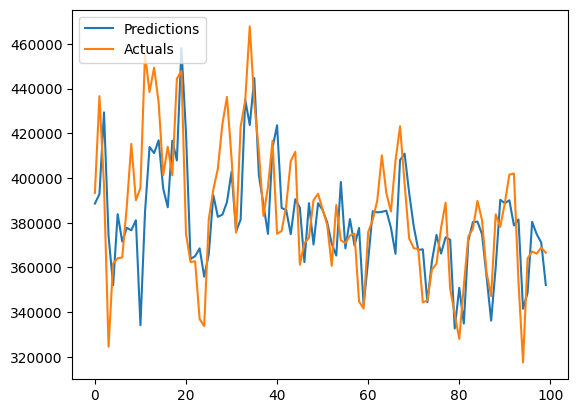

MAPE: 3.69%
RMSE: 18430.99
MAE : 14181.63


Predictions    Actuals
0    388577.93750  393359.12
1    392827.62500  436628.85
2    429383.06250  396547.46
3    374098.06250  324557.19
4    352070.71875  361764.59
..            ...        ...
350  374376.25000  405457.46
351  392717.62500  421027.63
352  395501.28125  407376.71
353  371464.31250  402263.51
354  372786.46875  405023.08

[355 rows x 2 columns]

In [71]:
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


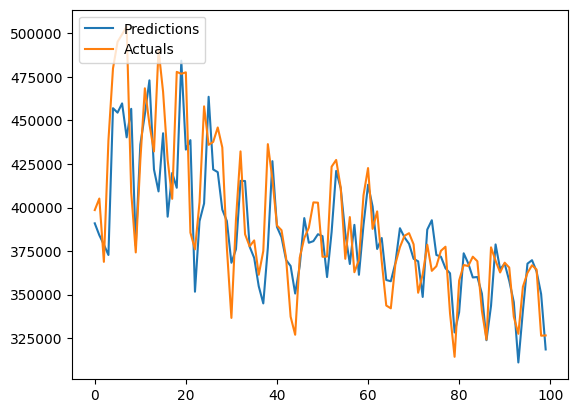

MAPE: 3.95%
RMSE: 20116.24
MAE : 15197.73


Predictions    Actuals
0    390940.06250  398542.65
1    384125.96875  405159.36
2    378741.09375  368840.45
3    372777.93750  438517.06
4    456995.90625  479784.41
..            ...        ...
350  360386.31250  360393.59
351  367252.68750  369325.03
352  371818.40625  371819.56
353  368902.75000  399427.25
354  391533.78125  408178.89

[355 rows x 2 columns]

In [72]:
predictions_plot(model7, X_test7, y_test7, 0, 100)

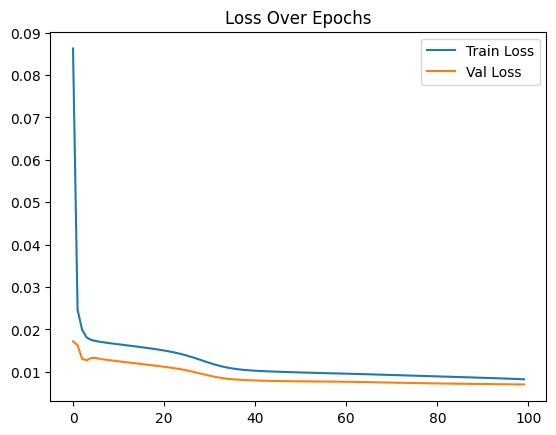

In [73]:
plt.plot(history7.history['loss'], label='Train Loss')
plt.plot(history7.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 8 - Decrease Window Size to 5 ##

In [82]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=5, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data8 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train8, y_train8 = data8['train']
X_val8, y_val8 = data8['val']
X_test8, y_test8 = data8['test']

i = X_train8.shape[1]
j = X_train8.shape[2]

In [83]:
model8 = Sequential()
model8.add(InputLayer((i, j)))
model8.add(LSTM(64))
model8.add(Dense(8, 'tanh'))
model8.add(Dense(1, 'linear'))

model8.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
cp8 = ModelCheckpoint('model8.keras', save_best_only=True)
model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])
history8 = model8.fit(X_train8, y_train8, validation_data=(X_val8, y_val8), epochs=100, callbacks=[cp8, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1142 - root_mean_squared_error: 0.3309 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1384
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0248 - root_mean_squared_error: 0.1574 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0210 - root_mean_squared_error: 0.1450 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1379 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179 - root_mean_squared_error: 0.1335 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1312 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


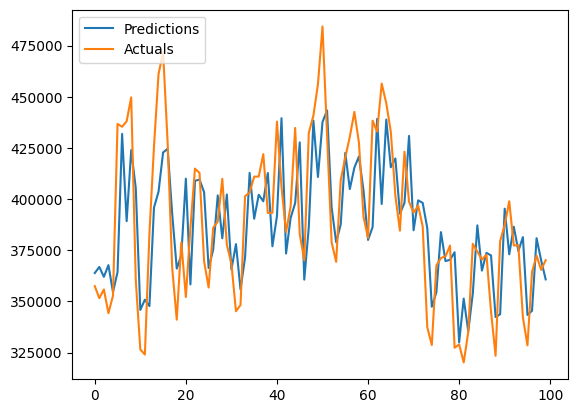

MAPE: 4.36%
RMSE: 22246.46
MAE : 16836.70


Predictions    Actuals
0    363847.84375  357451.06
1    366825.37500  351570.67
2    361996.93750  355814.96
3    367706.71875  344216.79
4    354533.68750  352812.68
..            ...        ...
721  353862.93750  353967.95
722  373728.75000  385900.00
723  386165.96875  411636.83
724  399519.65625  379656.38
725  357976.81250  342930.54

[726 rows x 2 columns]

In [85]:
model8 = load_model('model8.keras')

predictions_plot(model8, X_train8, y_train8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


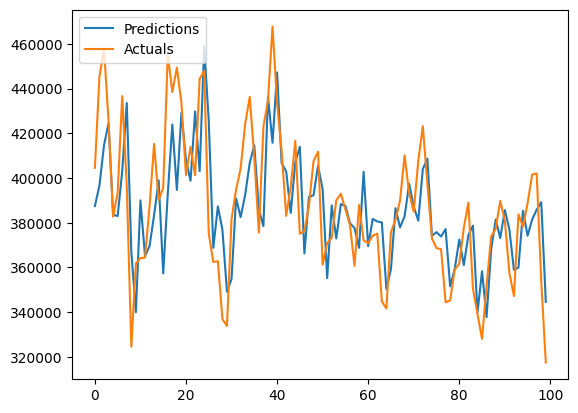

MAPE: 4.08%
RMSE: 19692.50
MAE : 15550.83


Predictions    Actuals
0    387464.84375  404557.93
1    396702.03125  445401.38
2    414632.75000  457780.70
3    424557.12500  425439.99
4    383561.50000  382741.80
..            ...        ...
355  367784.06250  405457.46
356  395080.43750  421027.63
357  391914.87500  407376.71
358  380857.93750  402263.51
359  387470.06250  405023.08

[360 rows x 2 columns]

In [86]:
predictions_plot(model8, X_val8, y_val8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


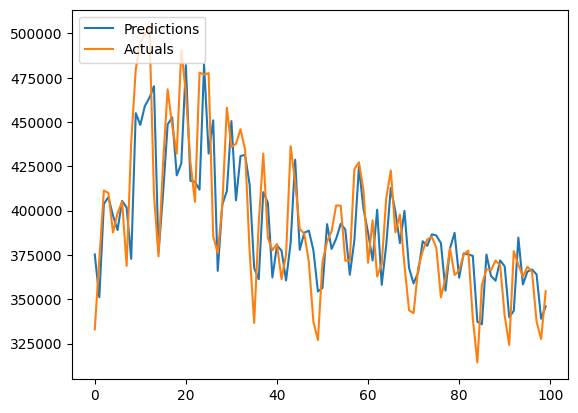

MAPE: 4.24%
RMSE: 20921.68
MAE : 16074.33


Predictions    Actuals
0    375294.75000  333009.61
1    351179.65625  372457.04
2    403844.09375  411339.27
3    407595.12500  409963.40
4    397231.25000  387672.63
..            ...        ...
355  364158.28125  360393.59
356  372978.78125  369325.03
357  370551.18750  371819.56
358  371404.53125  399427.25
359  395673.81250  408178.89

[360 rows x 2 columns]

In [87]:
predictions_plot(model8, X_test8, y_test8, 0, 100)

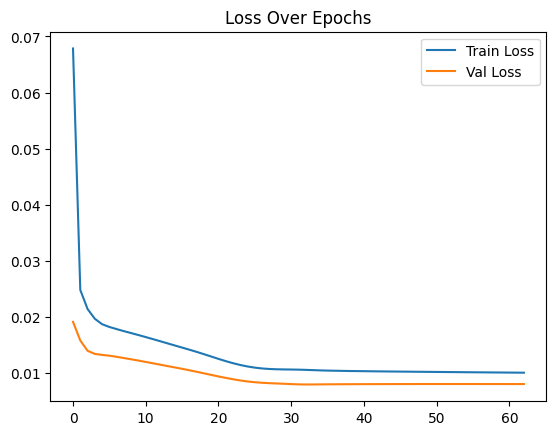

In [88]:
plt.plot(history8.history['loss'], label='Train Loss')
plt.plot(history8.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 9 - Increase Window Size to 14 ##

In [89]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=14, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data9 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train9, y_train9 = data9['train']
X_val9, y_val9 = data9['val']
X_test9, y_test9 = data9['test']

i = X_train9.shape[1]
j = X_train9.shape[2]

In [90]:
model9 = Sequential()
model9.add(InputLayer((i, j)))
model9.add(LSTM(64))
model9.add(Dense(8, 'tanh'))
model9.add(Dense(1, 'linear'))

model9.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
cp9 = ModelCheckpoint('model9.keras', save_best_only=True)
model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history9 = model9.fit(X_train9, y_train9, validation_data=(X_val9, y_val9), epochs=100, callbacks=[cp9, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1649 - root_mean_squared_error: 0.3965 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1488
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0287 - root_mean_squared_error: 0.1694 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1284
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0222 - root_mean_squared_error: 0.1491 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - root_mean_squared_error: 0.1416 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0190 - root_mean_squared_error: 0.1376 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0185 - root_mean_squared_error: 0.1360 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


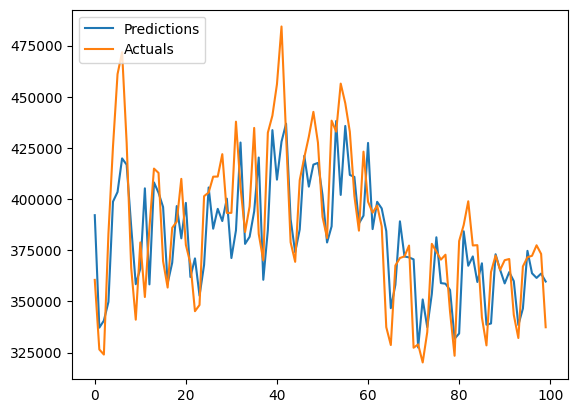

MAPE: 4.27%
RMSE: 21890.05
MAE : 16681.13


Predictions    Actuals
0    392120.93750  360495.64
1    337156.40625  326492.10
2    340597.62500  324006.75
3    349734.56250  383092.64
4    398744.62500  425665.84
..            ...        ...
712  365761.59375  353967.95
713  383339.93750  385900.00
714  392356.00000  411636.83
715  397824.34375  379656.38
716  355922.15625  342930.54

[717 rows x 2 columns]

In [92]:
model9 = load_model('model9.keras')

predictions_plot(model9, X_train9, y_train9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


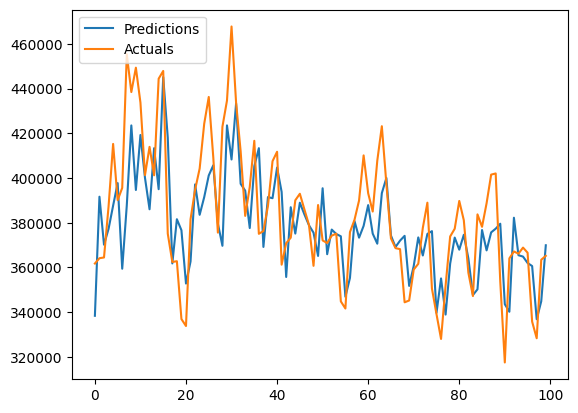

MAPE: 3.90%
RMSE: 19164.83
MAE : 14980.51


Predictions    Actuals
0    338381.18750  361764.59
1    391651.00000  364142.94
2    370174.28125  364469.53
3    377265.31250  387246.97
4    387648.03125  415263.41
..            ...        ...
346  370281.87500  405457.46
347  391476.34375  421027.63
348  387756.06250  407376.71
349  373655.06250  402263.51
350  376493.50000  405023.08

[351 rows x 2 columns]

In [93]:
predictions_plot(model9, X_val9, y_val9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


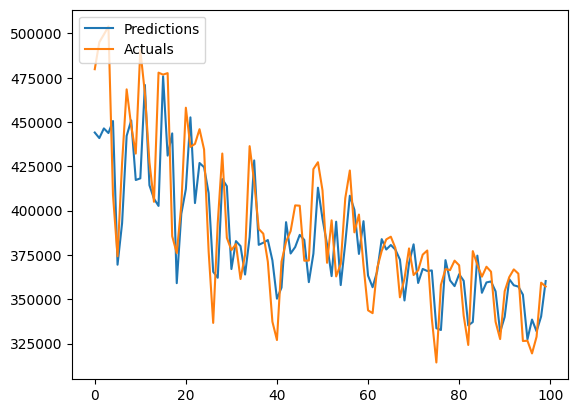

MAPE: 4.19%
RMSE: 20776.53
MAE : 16078.72


Predictions    Actuals
0    444069.31250  479784.41
1    440930.50000  495056.95
2    446375.78125  499342.29
3    443785.25000  503885.71
4    450564.40625  408832.77
..            ...        ...
346  361920.93750  360393.59
347  369523.96875  369325.03
348  367748.28125  371819.56
349  365163.81250  399427.25
350  386075.56250  408178.89

[351 rows x 2 columns]

In [94]:
predictions_plot(model9, X_test9, y_test9, 0, 100)

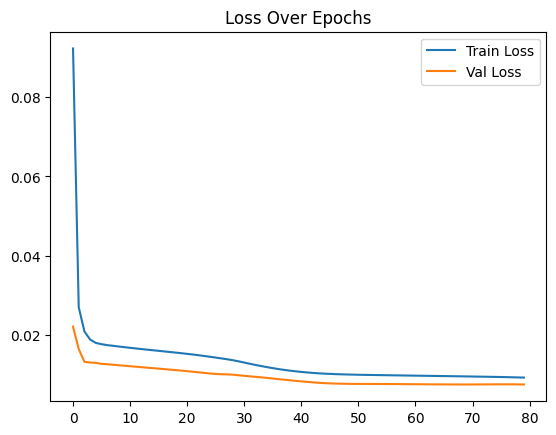

In [95]:
plt.plot(history9.history['loss'], label='Train Loss')
plt.plot(history9.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 10 - Add CDD/HDD ##

In [96]:
tempDemandDF5 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [97]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF5, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data10 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train10, y_train10 = data10['train']
X_val10, y_val10 = data10['val']
X_test10, y_test10 = data10['test']

i = X_train10.shape[1]
j = X_train10.shape[2]

In [98]:
model10 = Sequential()
model10.add(InputLayer((i, j)))
model10.add(LSTM(64))
model10.add(Dense(8, 'tanh'))
model10.add(Dense(1, 'linear'))

model10.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
cp10 = ModelCheckpoint('model10.keras', save_best_only=True)
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history10 = model10.fit(X_train10, y_train10, validation_data=(X_val10, y_val10), epochs=100, callbacks=[cp10, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0778 - root_mean_squared_error: 0.2715 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - root_mean_squared_error: 0.1238 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1160
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1186
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


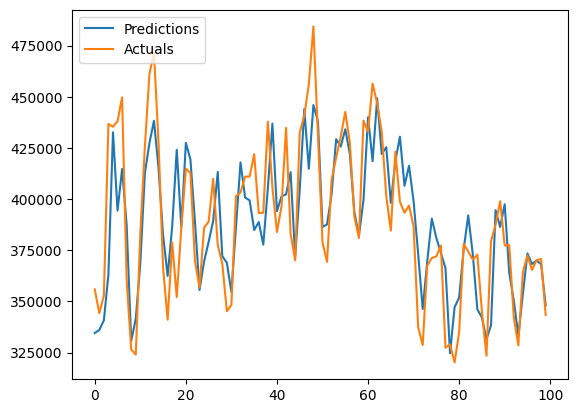

MAPE: 3.57%
RMSE: 18878.56
MAE : 13763.46


Predictions    Actuals
0    334509.03125  355814.96
1    336026.21875  344216.79
2    340750.46875  352812.68
3    363232.84375  436716.40
4    432658.53125  435360.14
..            ...        ...
719  385050.21875  353967.95
720  392858.31250  385900.00
721  393919.46875  411636.83
722  387467.87500  379656.38
723  350697.12500  342930.54

[724 rows x 2 columns]

In [100]:
model10 = load_model('model10.keras')
predictions_plot(model10, X_train10, y_train10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


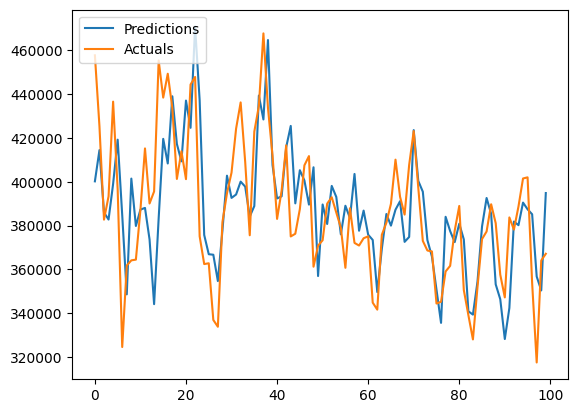

MAPE: 3.73%
RMSE: 18669.81
MAE : 14224.95


Predictions    Actuals
0    400221.68750  457780.70
1    414490.25000  425439.99
2    386031.34375  382741.80
3    382781.62500  393359.12
4    399063.37500  436628.85
..            ...        ...
353  382831.84375  405457.46
354  395910.40625  421027.63
355  394628.81250  407376.71
356  373375.40625  402263.51
357  368589.40625  405023.08

[358 rows x 2 columns]

In [101]:
predictions_plot(model10, X_val10, y_val10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


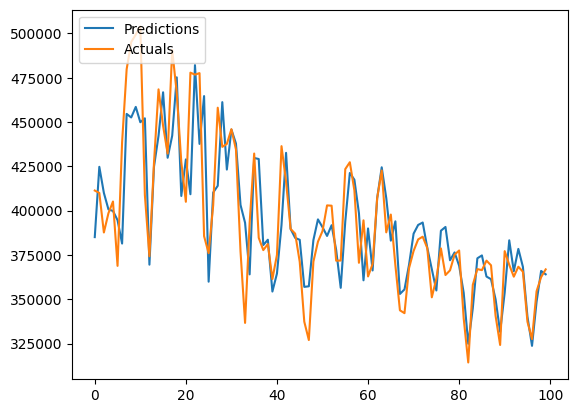

MAPE: 4.02%
RMSE: 20196.81
MAE : 15291.25


Predictions    Actuals
0    385061.81250  411339.27
1    424713.00000  409963.40
2    409998.12500  387672.63
3    400733.28125  398542.65
4    399805.62500  405159.36
..            ...        ...
353  379720.78125  360393.59
354  381282.43750  369325.03
355  378547.40625  371819.56
356  372693.31250  399427.25
357  364395.18750  408178.89

[358 rows x 2 columns]

In [102]:
predictions_plot(model10, X_test10, y_test10, 0, 100)

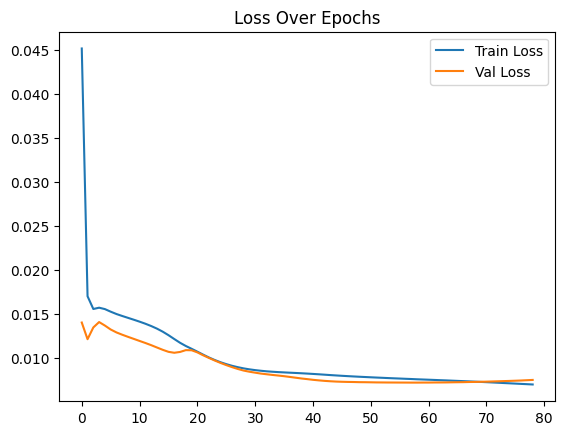

In [103]:
plt.plot(history10.history['loss'], label='Train Loss')
plt.plot(history10.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 11 - Remove Avg Temp from Model 10 ##

In [105]:
tempDemandDF6 = test_df[['sum_30_min_demand', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [106]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF6, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data11 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train11, y_train11 = data11['train']
X_val11, y_val11 = data11['val']
X_test11, y_test11 = data11['test']

i = X_train11.shape[1]
j = X_train11.shape[2]

In [107]:
model11 = Sequential()
model11.add(InputLayer((i, j)))
model11.add(LSTM(64))
model11.add(Dense(8, 'tanh'))
model11.add(Dense(1, 'linear'))

model11.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:
cp11 = ModelCheckpoint('model11.keras', save_best_only=True)
model11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history11 = model11.fit(X_train11, y_train11, validation_data=(X_val11, y_val11), epochs=100, callbacks=[cp11, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0786 - root_mean_squared_error: 0.2730 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1239
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0204 - root_mean_squared_error: 0.1426 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - root_mean_squared_error: 0.1298 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.1294 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1225
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166 - root_mean_squared_error: 0.1286 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1198
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


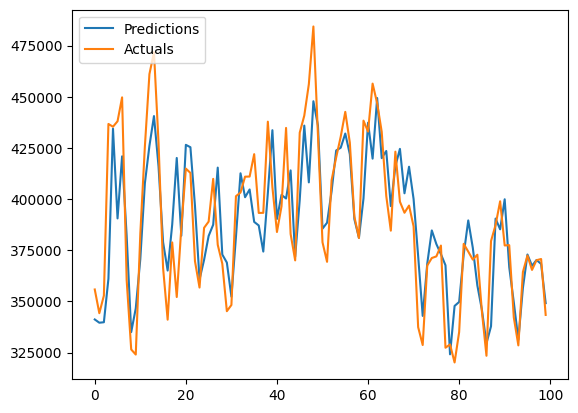

MAPE: 3.41%
RMSE: 18227.14
MAE : 13136.22


Predictions    Actuals
0    341160.03125  355814.96
1    339563.68750  344216.79
2    339800.43750  352812.68
3    361081.59375  436716.40
4    434413.18750  435360.14
..            ...        ...
719  381847.68750  353967.95
720  395195.37500  385900.00
721  405144.40625  411636.83
722  394765.28125  379656.38
723  358775.93750  342930.54

[724 rows x 2 columns]

In [109]:
model11 = load_model('model11.keras')

predictions_plot(model11, X_train11, y_train11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


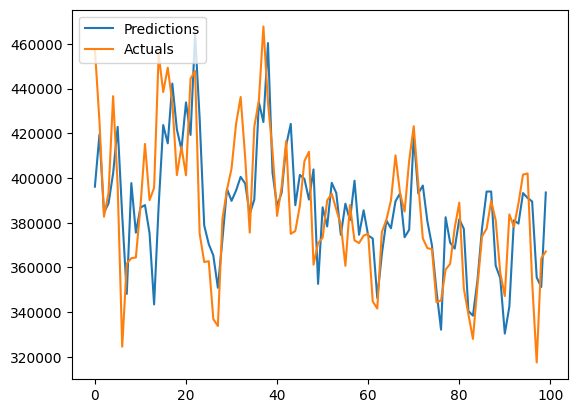

MAPE: 3.52%
RMSE: 17885.58
MAE : 13407.77


Predictions    Actuals
0    396140.31250  457780.70
1    419444.59375  425439.99
2    384516.56250  382741.80
3    388686.87500  393359.12
4    402064.96875  436628.85
..            ...        ...
353  380994.71875  405457.46
354  404088.37500  421027.63
355  404082.28125  407376.71
356  383089.71875  402263.51
357  374670.18750  405023.08

[358 rows x 2 columns]

In [110]:
predictions_plot(model11, X_val11, y_val11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


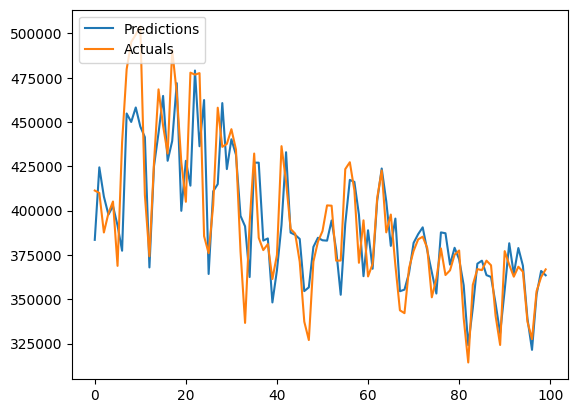

MAPE: 3.89%
RMSE: 19680.42
MAE : 14760.64


Predictions    Actuals
0    383528.71875  411339.27
1    424415.25000  409963.40
2    407941.31250  387672.63
3    397766.21875  398542.65
4    402611.81250  405159.36
..            ...        ...
353  383047.06250  360393.59
354  388448.06250  369325.03
355  389046.50000  371819.56
356  386565.50000  399427.25
357  362548.62500  408178.89

[358 rows x 2 columns]

In [111]:
predictions_plot(model11, X_test11, y_test11, 0, 100)

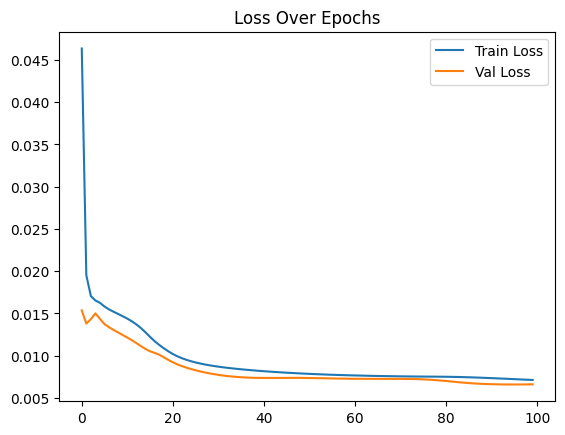

In [112]:
plt.plot(history11.history['loss'], label='Train Loss')
plt.plot(history11.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Introduce Other Weather Features ##

## Model 12 - Precipitation ##

In [113]:
tempPrecipDemandDF = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'temp_range']].copy()

In [114]:
preprocessor = TimeSeriesPreprocessorTVT(tempPrecipDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data12 = preprocessor.get_model_inputs(target_col = 'sum_30_min_demand')

X_train12, y_train12 = data12['train']
X_val12, y_val12 = data12['val']
X_test12, y_test12 = data12['test']

i = X_train12.shape[1]
j = X_train12.shape[2]

In [115]:
model12 = Sequential()
model12.add(InputLayer((i, j)))
model12.add(LSTM(64))
model12.add(Dense(8, 'tanh'))
model12.add(Dense(1, 'linear'))

model12.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
cp12 = ModelCheckpoint('model12.keras', save_best_only=True)
model12.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history12 = model12.fit(X_train12, y_train12, validation_data=(X_val12, y_val12), epochs=100, callbacks=[cp12, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0428 - root_mean_squared_error: 0.2034 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1364
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0159 - root_mean_squared_error: 0.1260 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - root_mean_squared_error: 0.1223 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1084
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


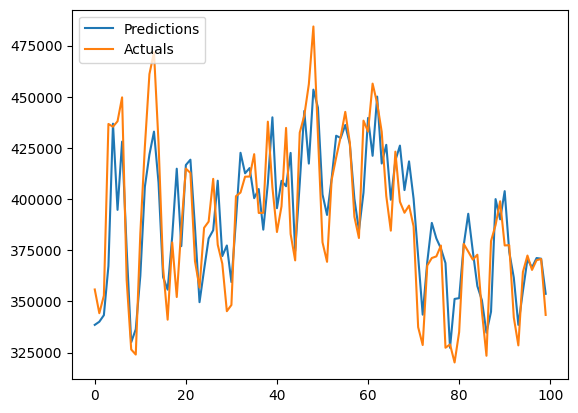

MAPE: 3.38%
RMSE: 17605.44
MAE : 13018.31


Predictions    Actuals
0    338513.37500  355814.96
1    340051.06250  344216.79
2    343254.25000  352812.68
3    367294.50000  436716.40
4    436854.81250  435360.14
..            ...        ...
719  385028.21875  353967.95
720  402832.21875  385900.00
721  403501.84375  411636.83
722  385146.15625  379656.38
723  354735.62500  342930.54

[724 rows x 2 columns]

In [117]:
model12 = load_model('model12.keras')

predictions_plot(model12, X_train12, y_train12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


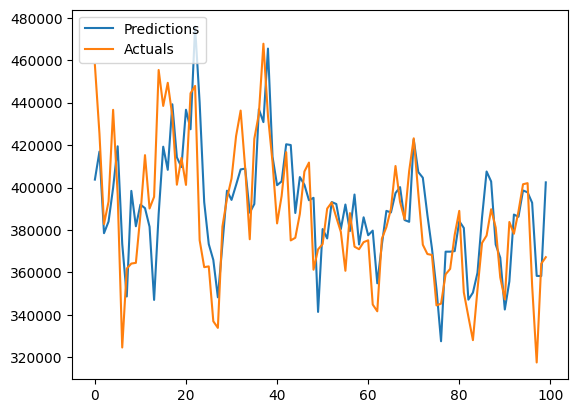

MAPE: 3.48%
RMSE: 17615.18
MAE : 13202.36


Predictions    Actuals
0    403733.28125  457780.70
1    416952.90625  425439.99
2    378457.68750  382741.80
3    383966.71875  393359.12
4    399861.18750  436628.85
..            ...        ...
353  389207.43750  405457.46
354  409382.71875  421027.63
355  412146.18750  407376.71
356  389996.00000  402263.51
357  386393.53125  405023.08

[358 rows x 2 columns]

In [118]:
predictions_plot(model12, X_val12, y_val12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


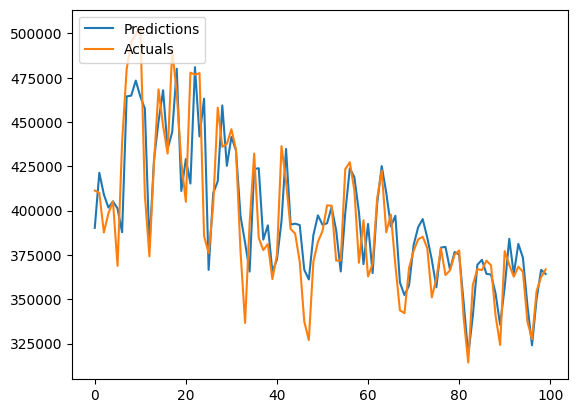

MAPE: 3.88%
RMSE: 19233.35
MAE : 14607.90


Predictions    Actuals
0    390295.40625  411339.27
1    421350.09375  409963.40
2    409087.96875  387672.63
3    401740.43750  398542.65
4    405225.50000  405159.36
..            ...        ...
353  392787.21875  360393.59
354  396850.21875  369325.03
355  396645.78125  371819.56
356  392776.12500  399427.25
357  377995.87500  408178.89

[358 rows x 2 columns]

In [119]:
predictions_plot(model12, X_test12, y_test12, 0, 100)

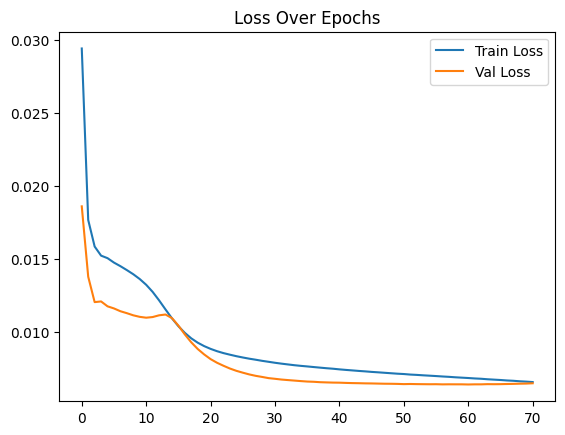

In [120]:
plt.plot(history12.history['loss'], label='Train Loss')
plt.plot(history12.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 13 - Sunlight ##

In [121]:
tempSunDemandDF = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'sunlight', 'temp_range']].copy()

In [122]:
preprocessor = TimeSeriesPreprocessorTVT(tempSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data13 = preprocessor.get_model_inputs(target_col = 'sum_30_min_demand')

X_train13, y_train13 = data13['train']
X_val13, y_val13 = data13['val']
X_test13, y_test13 = data13['test']

i = X_train13.shape[1]
j = X_train13.shape[2]

In [123]:
model13 = Sequential()
model13.add(InputLayer((i, j)))
model13.add(LSTM(64))
model13.add(Dense(8, 'tanh'))
model13.add(Dense(1, 'linear'))

model13.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
cp13 = ModelCheckpoint('model13.keras', save_best_only=True)
model13.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history13 = model13.fit(X_train13, y_train13, validation_data=(X_val13, y_val13), epochs=100, callbacks=[cp13, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0505 - root_mean_squared_error: 0.2207 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1238
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1282 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1181
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1129
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


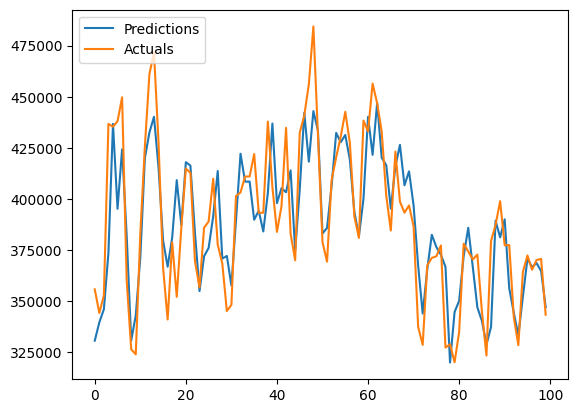

MAPE: 3.51%
RMSE: 18471.61
MAE : 13511.79


Predictions    Actuals
0    330703.68750  355814.96
1    339645.34375  344216.79
2    346051.56250  352812.68
3    373692.43750  436716.40
4    436704.21875  435360.14
..            ...        ...
719  373633.90625  353967.95
720  390919.62500  385900.00
721  394069.68750  411636.83
722  388860.56250  379656.38
723  352254.21875  342930.54

[724 rows x 2 columns]

In [125]:
model13 = load_model('model13.keras')
predictions_plot(model13, X_train13, y_train13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


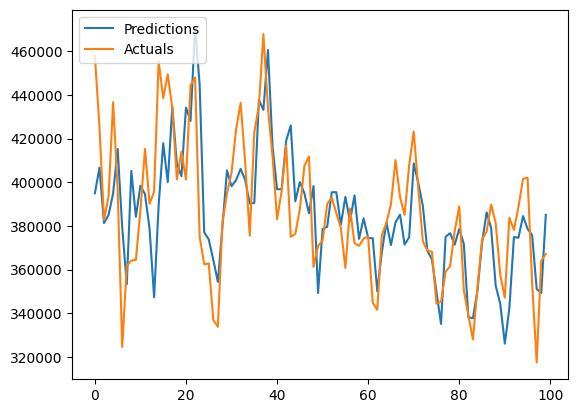

MAPE: 3.70%
RMSE: 18598.77
MAE : 14095.74


Predictions    Actuals
0    394939.03125  457780.70
1    406656.00000  425439.99
2    381316.78125  382741.80
3    385025.21875  393359.12
4    394871.34375  436628.85
..            ...        ...
353  395929.62500  405457.46
354  408613.78125  421027.63
355  408418.53125  407376.71
356  386289.75000  402263.51
357  379634.84375  405023.08

[358 rows x 2 columns]

In [126]:
predictions_plot(model13, X_val13, y_val13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


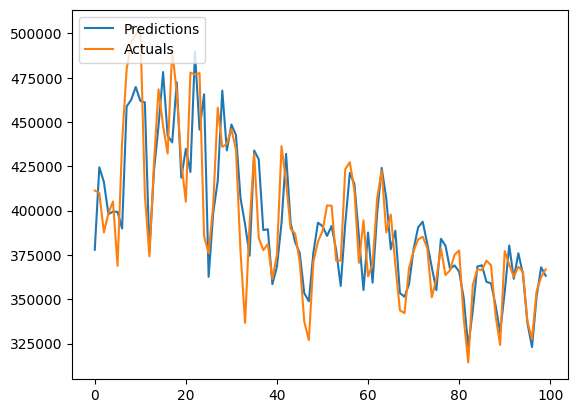

MAPE: 3.91%
RMSE: 19680.12
MAE : 14853.67


Predictions    Actuals
0    377947.71875  411339.27
1    424481.21875  409963.40
2    416203.43750  387672.63
3    398014.90625  398542.65
4    399450.46875  405159.36
..            ...        ...
353  385178.93750  360393.59
354  388475.53125  369325.03
355  389398.37500  371819.56
356  380980.75000  399427.25
357  375268.37500  408178.89

[358 rows x 2 columns]

In [127]:
predictions_plot(model13, X_test13, y_test13, 0, 100)

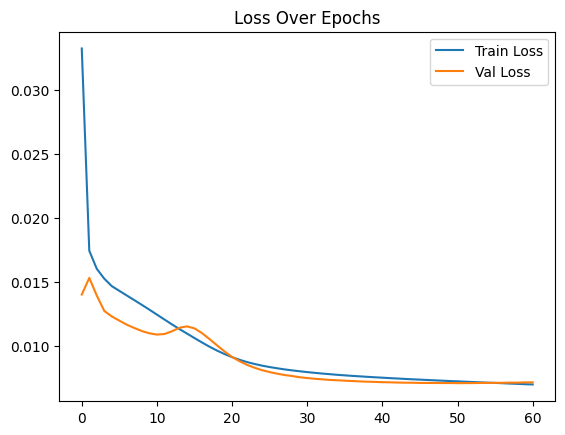

In [128]:
plt.plot(history13.history['loss'], label='Train Loss')
plt.plot(history13.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 14 - Precipitation and Sunlight ##

In [129]:
tempPreSunDemandDF = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight', 'temp_range']].copy()


In [130]:
preprocessor = TimeSeriesPreprocessorTVT(tempPreSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data14 = preprocessor.get_model_inputs(target_col = 'sum_30_min_demand')

X_train14, y_train14 = data14['train']
X_val14, y_val14 = data14['val']
X_test14, y_test14 = data14['test']

i = X_train14.shape[1]
j = X_train14.shape[2]

In [131]:
model14 = Sequential()
model14.add(InputLayer((i, j)))
model14.add(LSTM(64))
model14.add(Dense(8, 'tanh'))
model14.add(Dense(1, 'linear'))

model14.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
cp14 = ModelCheckpoint('model14.keras', save_best_only=True)
model14.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history14 = model14.fit(X_train14, y_train14, validation_data=(X_val14, y_val14), epochs=100, callbacks=[cp14, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1048 - root_mean_squared_error: 0.3146 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1437
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0220 - root_mean_squared_error: 0.1480 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0158 - root_mean_squared_error: 0.1257 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1148
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - root_mean_squared_error: 0.1223 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


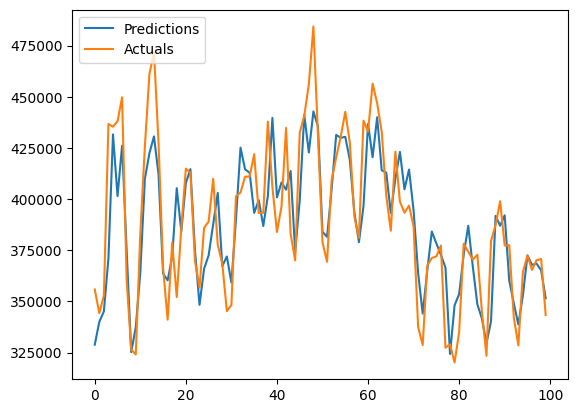

MAPE: 3.49%
RMSE: 18170.99
MAE : 13447.68


Predictions    Actuals
0    328839.84375  355814.96
1    340023.78125  344216.79
2    345100.25000  352812.68
3    371012.93750  436716.40
4    431590.59375  435360.14
..            ...        ...
719  373758.65625  353967.95
720  399584.53125  385900.00
721  393644.31250  411636.83
722  379215.03125  379656.38
723  349644.09375  342930.54

[724 rows x 2 columns]

In [133]:
model14 = load_model('model14.keras')

predictions_plot(model14, X_train14, y_train14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


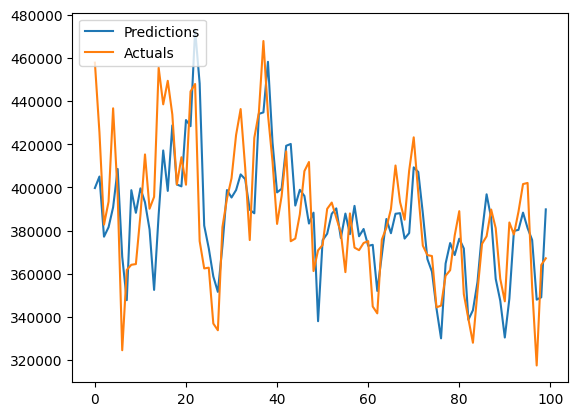

MAPE: 3.64%
RMSE: 18200.20
MAE : 13868.01


Predictions    Actuals
0    399697.06250  457780.70
1    405023.37500  425439.99
2    377162.37500  382741.80
3    381529.71875  393359.12
4    390776.96875  436628.85
..            ...        ...
353  397368.09375  405457.46
354  414801.96875  421027.63
355  415172.31250  407376.71
356  394150.37500  402263.51
357  390199.34375  405023.08

[358 rows x 2 columns]

In [134]:
predictions_plot(model14, X_val14, y_val14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


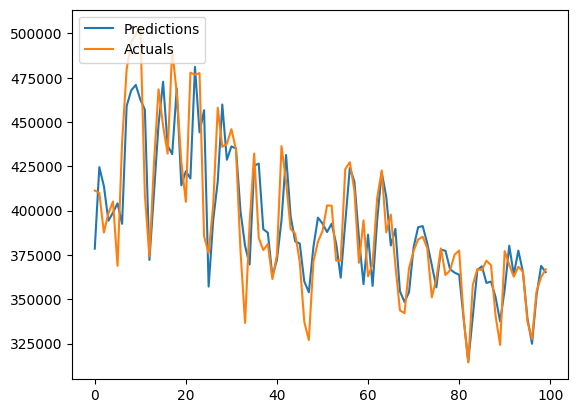

MAPE: 3.94%
RMSE: 19587.08
MAE : 14876.36


Predictions    Actuals
0    378565.87500  411339.27
1    424525.43750  409963.40
2    413847.81250  387672.63
3    394307.59375  398542.65
4    398897.50000  405159.36
..            ...        ...
353  389124.15625  360393.59
354  395516.43750  369325.03
355  396667.25000  371819.56
356  389283.40625  399427.25
357  382764.50000  408178.89

[358 rows x 2 columns]

In [135]:
predictions_plot(model14, X_test14, y_test14, 0, 100)

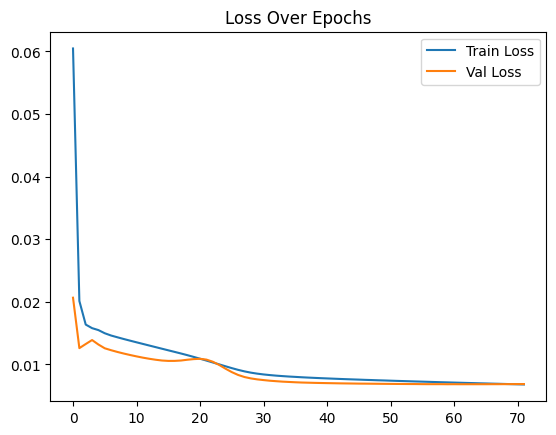

In [136]:
plt.plot(history14.history['loss'], label='Train Loss')
plt.plot(history14.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Seasonality ##

## Seasons ##

In [139]:
seasonsDemandDF = test_df[['is_winter', 'is_spring', 'is_summer', 'is_autumn','sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [140]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data15 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train15, y_train15 = data15['train']
X_val15, y_val15 = data15['val']
X_test15, y_test15 = data15['test']

i = X_train15.shape[1]
j = X_train15.shape[2]

In [141]:
model15 = Sequential()
model15.add(InputLayer((i, j)))
model15.add(LSTM(64))
model15.add(Dense(8, 'tanh'))
model15.add(Dense(1, 'linear'))

model15.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
cp15 = ModelCheckpoint('model15.keras', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history15 = model15.fit(X_train15, y_train15, validation_data=(X_val15, y_val15), epochs=100, callbacks=[cp15, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1036 - root_mean_squared_error: 0.3112 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0162 - root_mean_squared_error: 0.1272 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


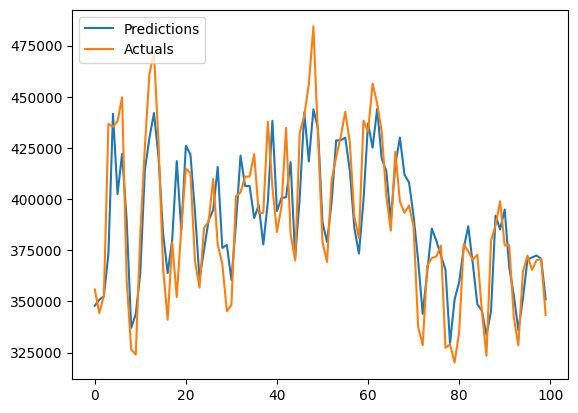

MAPE: 3.43%
RMSE: 18301.66
MAE : 13214.53


Predictions    Actuals
0    347840.40625  355814.96
1    350865.65625  344216.79
2    352467.09375  352812.68
3    373366.18750  436716.40
4    441674.87500  435360.14
..            ...        ...
719  379770.43750  353967.95
720  393458.84375  385900.00
721  394746.93750  411636.83
722  395692.53125  379656.38
723  355748.28125  342930.54

[724 rows x 2 columns]

In [143]:
model15 = load_model('model15.keras')

predictions_plot(model15, X_train15, y_train15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


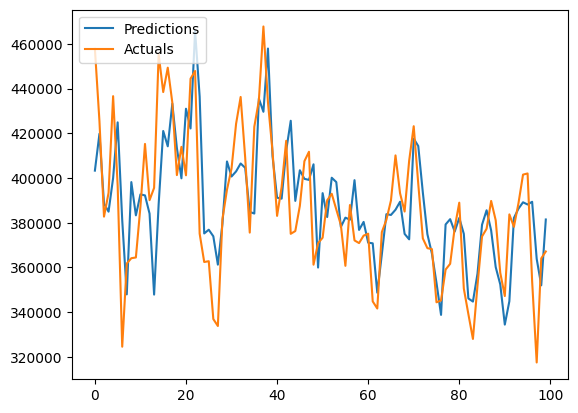

MAPE: 3.55%
RMSE: 17770.71
MAE : 13506.25


Predictions    Actuals
0    403314.84375  457780.70
1    419822.21875  425439.99
2    388560.75000  382741.80
3    384966.28125  393359.12
4    400011.75000  436628.85
..            ...        ...
353  389366.37500  405457.46
354  404115.21875  421027.63
355  405289.31250  407376.71
356  381220.03125  402263.51
357  376556.68750  405023.08

[358 rows x 2 columns]

In [144]:
predictions_plot(model15, X_val15, y_val15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


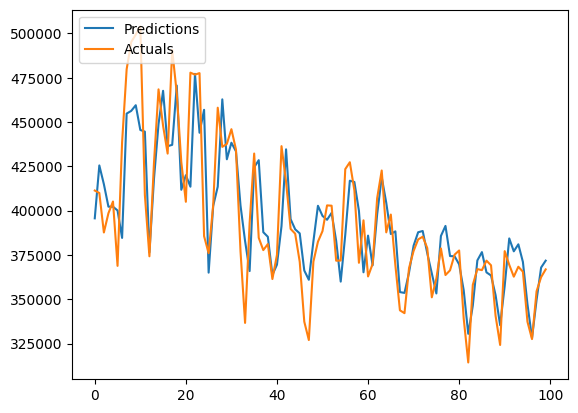

MAPE: 3.83%
RMSE: 19220.12
MAE : 14511.80


Predictions    Actuals
0    395651.46875  411339.27
1    425496.84375  409963.40
2    414917.40625  387672.63
3    402235.96875  398542.65
4    402226.93750  405159.36
..            ...        ...
353  382434.84375  360393.59
354  381813.56250  369325.03
355  383676.68750  371819.56
356  376732.09375  399427.25
357  380553.43750  408178.89

[358 rows x 2 columns]

In [145]:
predictions_plot(model15, X_test15, y_test15, 0, 100)

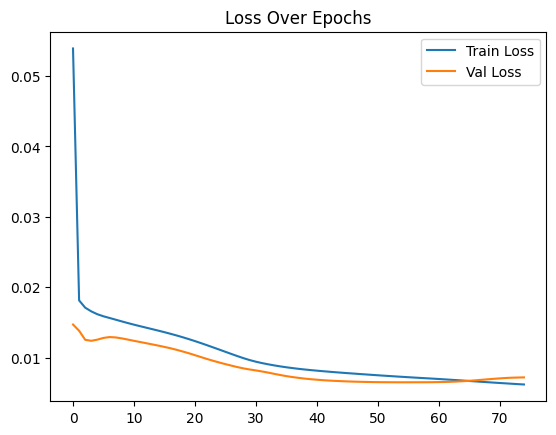

In [146]:
plt.plot(history15.history['loss'], label='Train Loss')
plt.plot(history15.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Weekday/Weekend ##

In [147]:
weekendDemandDF = test_df[['is_weekday', 'is_weekend', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [148]:
preprocessor = TimeSeriesPreprocessorTVT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data16 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train16, y_train16 = data16['train']
X_val16, y_val16 = data16['val']
X_test16, y_test16 = data16['test']

i = X_train16.shape[1]
j = X_train16.shape[2]

In [149]:
model16 = Sequential()
model16.add(InputLayer((7, 9)))
model16.add(LSTM(64))
model16.add(Dense(8, 'tanh'))
model16.add(Dense(1, 'linear'))

model16.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
cp16 = ModelCheckpoint('model16.keras', save_best_only=True)
model16.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history16 = model16.fit(X_train16, y_train16, validation_data=(X_val16, y_val16), epochs=100, callbacks=[cp16, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1501 - root_mean_squared_error: 0.3746 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - root_mean_squared_error: 0.1281 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


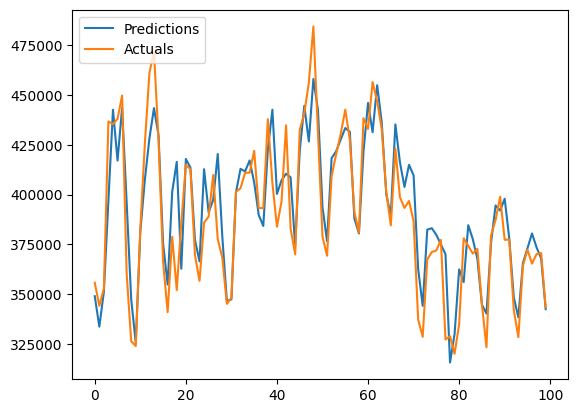

MAPE: 2.80%
RMSE: 15004.73
MAE : 10707.37


Predictions    Actuals
0    349038.81250  355814.96
1    333749.34375  344216.79
2    351282.03125  352812.68
3    397380.15625  436716.40
4    442573.62500  435360.14
..            ...        ...
719  356089.03125  353967.95
720  380903.28125  385900.00
721  389258.31250  411636.83
722  374316.56250  379656.38
723  353311.50000  342930.54

[724 rows x 2 columns]

In [151]:
model16 = load_model('model16.keras')

predictions_plot(model16, X_train16, y_train16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


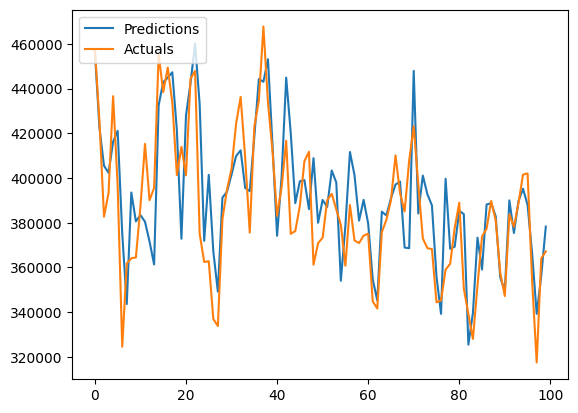

MAPE: 3.11%
RMSE: 16020.32
MAE : 11780.53


Predictions    Actuals
0    456404.37500  457780.70
1    422531.68750  425439.99
2    405514.06250  382741.80
3    402335.09375  393359.12
4    416282.18750  436628.85
..            ...        ...
353  365356.75000  405457.46
354  387897.06250  421027.63
355  375475.00000  407376.71
356  380617.53125  402263.51
357  421434.37500  405023.08

[358 rows x 2 columns]

In [152]:
predictions_plot(model16, X_val16, y_val16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


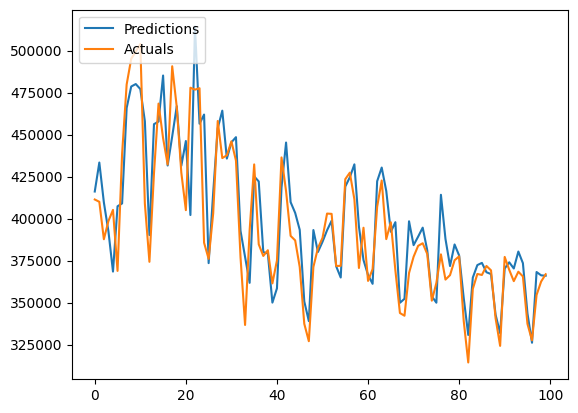

MAPE: 3.31%
RMSE: 17187.96
MAE : 12568.85


Predictions    Actuals
0    416079.37500  411339.27
1    433334.09375  409963.40
2    409560.81250  387672.63
3    392377.53125  398542.65
4    368440.31250  405159.36
..            ...        ...
353  351125.75000  360393.59
354  337787.81250  369325.03
355  370119.75000  371819.56
356  410908.40625  399427.25
357  404260.09375  408178.89

[358 rows x 2 columns]

In [153]:
predictions_plot(model16, X_test16, y_test16, 0, 100)

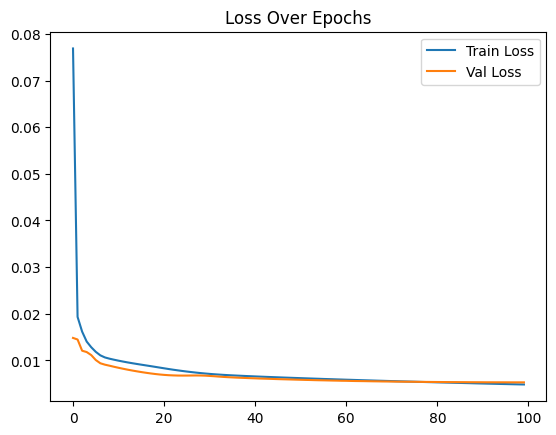

In [154]:
plt.plot(history16.history['loss'], label='Train Loss')
plt.plot(history16.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Day Of Week ##

In [155]:
dayDemandDF = test_df[['is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [156]:
preprocessor = TimeSeriesPreprocessorTVT(dayDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data17 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train17, y_train17 = data17['train']
X_val17, y_val17 = data17['val']
X_test17, y_test17 = data17['test']

i = X_train17.shape[1]
j = X_train17.shape[2]

In [157]:
model17 = Sequential()
model17.add(InputLayer((i, j)))
model17.add(LSTM(64))
model17.add(Dense(8, 'tanh'))
model17.add(Dense(1, 'linear'))

model17.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
cp17 = ModelCheckpoint('model17.keras', save_best_only=True)
model17.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history17 = model17.fit(X_train17, y_train17, validation_data=(X_val17, y_val17), epochs=100, callbacks=[cp17, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0575 - root_mean_squared_error: 0.2345 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0987
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0930
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


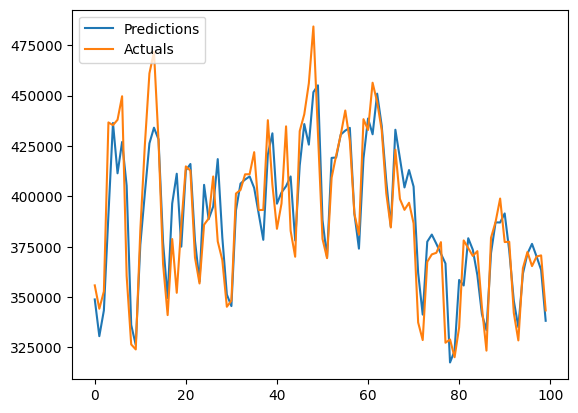

MAPE: 2.68%
RMSE: 15003.21
MAE : 10368.18


Predictions    Actuals
0    348830.87500  355814.96
1    330590.00000  344216.79
2    343372.59375  352812.68
3    390893.93750  436716.40
4    436446.87500  435360.14
..            ...        ...
719  350230.93750  353967.95
720  382186.34375  385900.00
721  380808.62500  411636.83
722  377307.31250  379656.38
723  351886.21875  342930.54

[724 rows x 2 columns]

In [159]:
model17 = load_model('model17.keras')

predictions_plot(model17, X_train17, y_train17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


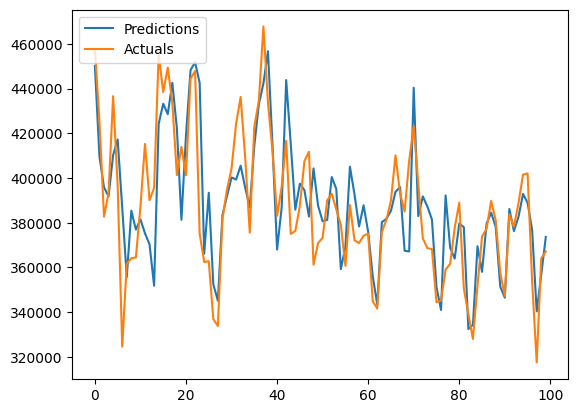

MAPE: 2.92%
RMSE: 15428.77
MAE : 11121.69


Predictions    Actuals
0    450108.06250  457780.70
1    409652.53125  425439.99
2    395848.28125  382741.80
3    391797.40625  393359.12
4    410248.18750  436628.85
..            ...        ...
353  363493.43750  405457.46
354  381679.00000  421027.63
355  378234.65625  407376.71
356  366296.06250  402263.51
357  411783.31250  405023.08

[358 rows x 2 columns]

In [160]:
predictions_plot(model17, X_val17, y_val17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


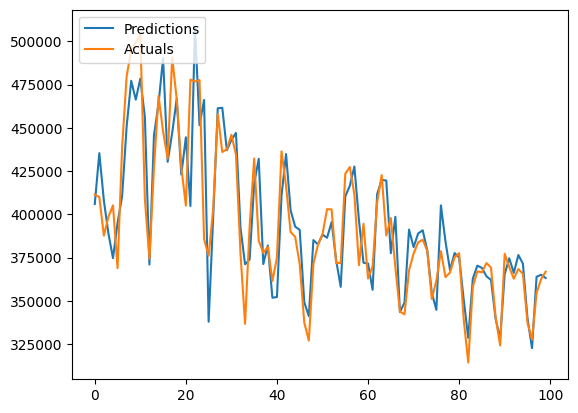

MAPE: 3.22%
RMSE: 17000.93
MAE : 12288.03


Predictions    Actuals
0    405920.81250  411339.27
1    435328.31250  409963.40
2    407882.84375  387672.63
3    388887.50000  398542.65
4    374680.31250  405159.36
..            ...        ...
353  351553.56250  360393.59
354  338789.15625  369325.03
355  355117.59375  371819.56
356  401317.21875  399427.25
357  390092.62500  408178.89

[358 rows x 2 columns]

In [161]:
predictions_plot(model17, X_test17, y_test17, 0, 100)

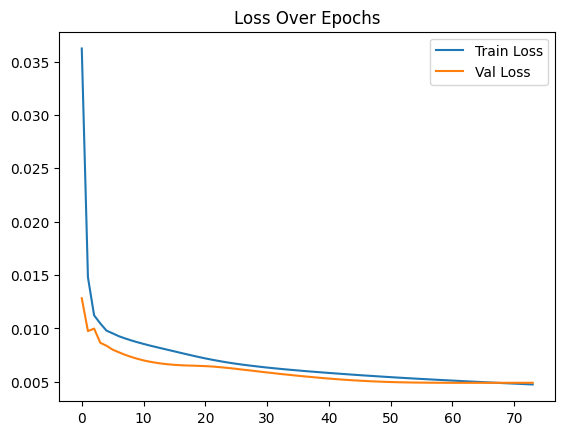

In [162]:
plt.plot(history17.history['loss'], label='Train Loss')
plt.plot(history17.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Month ##

In [185]:
monthDemandDF = test_df[['is_jan', 'is_feb', 'is_mar','is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct','is_nov', 'is_dec', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [186]:
preprocessor = TimeSeriesPreprocessorTVT(monthDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data18 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train18, y_train18 = data18['train']
X_val18, y_val18 = data18['val']
X_test18, y_test18 = data18['test']

i = X_train18.shape[1]
j = X_train18.shape[2]

In [187]:
model18 = Sequential()
model18.add(InputLayer((i, j)))
model18.add(LSTM(64))
model18.add(Dense(8, 'tanh'))
model18.add(Dense(1, 'linear'))

model18.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,033 (86.07 KB)

 Trainable params: 22,033 (86.07 KB)

 Non-trainable params: 0 (0.00 B)

In [188]:
cp18 = ModelCheckpoint('model18.keras', save_best_only=True)
model18.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history18 = model18.fit(X_train18, y_train18, validation_data=(X_val18, y_val18), epochs=100, callbacks=[cp18, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1310 - root_mean_squared_error: 0.3501 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0162 - root_mean_squared_error: 0.1270 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


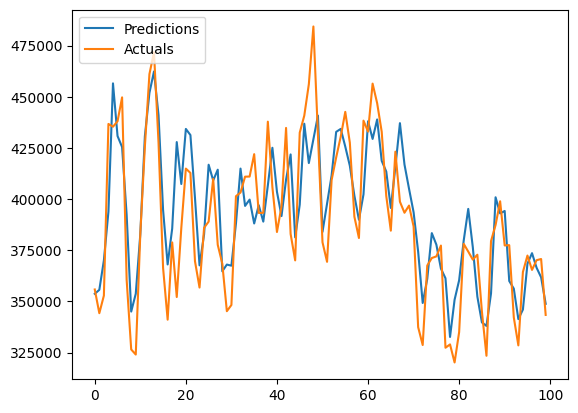

MAPE: 3.63%
RMSE: 18396.19
MAE : 13915.05


Predictions    Actuals
0    353702.65625  355814.96
1    355644.28125  344216.79
2    370017.84375  352812.68
3    393840.18750  436716.40
4    456558.03125  435360.14
..            ...        ...
719  381058.03125  353967.95
720  400022.71875  385900.00
721  403714.09375  411636.83
722  405136.40625  379656.38
723  370138.37500  342930.54

[724 rows x 2 columns]

In [189]:
model18 = load_model('model18.keras')

predictions_plot(model18, X_train18, y_train18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


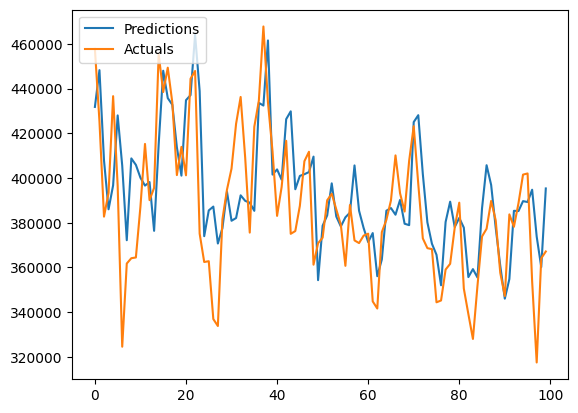

MAPE: 3.94%
RMSE: 19411.53
MAE : 14839.58


Predictions    Actuals
0    431811.37500  457780.70
1    448271.71875  425439.99
2    407893.37500  382741.80
3    386024.75000  393359.12
4    396726.06250  436628.85
..            ...        ...
353  388737.75000  405457.46
354  402015.40625  421027.63
355  404974.71875  407376.71
356  383281.65625  402263.51
357  376705.18750  405023.08

[358 rows x 2 columns]

In [190]:
predictions_plot(model18, X_val18, y_val18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


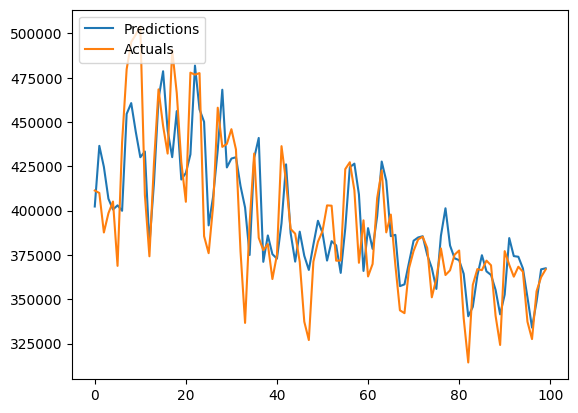

MAPE: 4.23%
RMSE: 20847.70
MAE : 15870.75


Predictions    Actuals
0    402332.78125  411339.27
1    436544.65625  409963.40
2    424699.46875  387672.63
3    406701.50000  398542.65
4    400634.37500  405159.36
..            ...        ...
353  383471.21875  360393.59
354  393965.87500  369325.03
355  391135.84375  371819.56
356  386083.93750  399427.25
357  392159.71875  408178.89

[358 rows x 2 columns]

In [191]:
predictions_plot(model18, X_test18, y_test18, 0, 100)

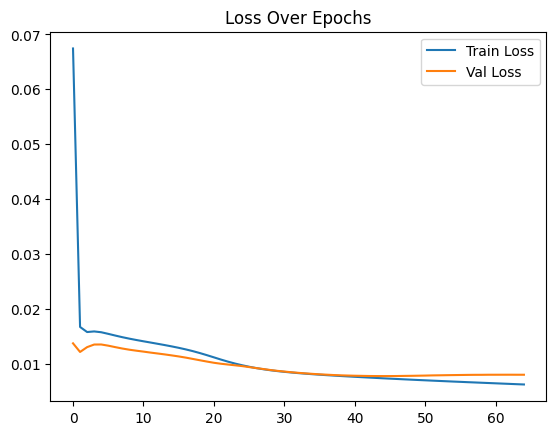

In [192]:
plt.plot(history18.history['loss'], label='Train Loss')
plt.plot(history18.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Seasons & Weekday/Weekend ##

In [193]:
seasonsWdWeDemandDF = test_df[['is_weekend','is_weekday','is_winter', 'is_spring', 'is_summer', 'is_autumn','sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [194]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data19 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train19, y_train19 = data19['train']
X_val19, y_val19 = data19['val']
X_test19, y_test19 = data19['test']

i = X_train19.shape[1]
j = X_train19.shape[2]

In [195]:
model19 = Sequential()
model19.add(InputLayer((i, j)))
model19.add(LSTM(64))
model19.add(Dense(8, 'tanh'))
model19.add(Dense(1, 'linear'))

model19.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [196]:
cp19 = ModelCheckpoint('model19.keras', save_best_only=True)
model19.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history19 = model19.fit(X_train19, y_train19, validation_data=(X_val19, y_val19), epochs=100, callbacks=[cp19, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0601 - root_mean_squared_error: 0.2382 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0152 - root_mean_squared_error: 0.1231 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - root_mean_squared_error: 0.1178 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121 - root_mean_squared_error: 0.1101 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0931
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0108 - root_mean_squared_error: 0.1040 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


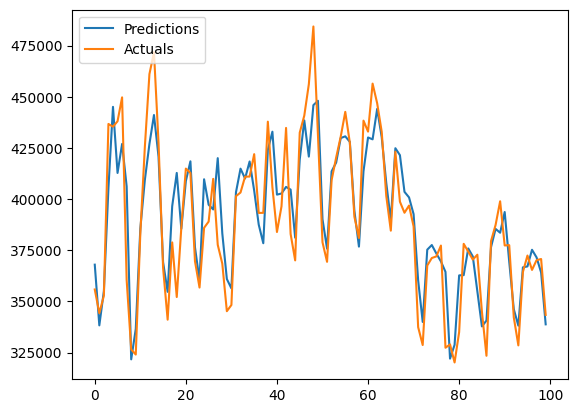

MAPE: 2.97%
RMSE: 16354.93
MAE : 11435.11


Predictions    Actuals
0    367944.21875  355814.96
1    338267.37500  344216.79
2    355015.75000  352812.68
3    405381.12500  436716.40
4    445072.56250  435360.14
..            ...        ...
719  364505.56250  353967.95
720  385437.09375  385900.00
721  386084.50000  411636.83
722  375697.40625  379656.38
723  358941.71875  342930.54

[724 rows x 2 columns]

In [197]:
model19 = load_model('model19.keras')

predictions_plot(model19, X_train19, y_train19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


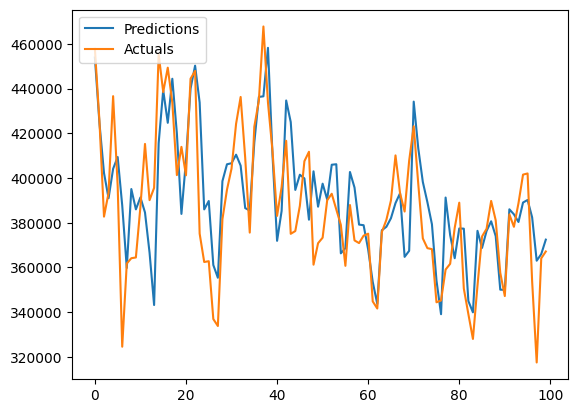

MAPE: 3.23%
RMSE: 16818.82
MAE : 12254.15


Predictions    Actuals
0    453887.81250  457780.70
1    424585.87500  425439.99
2    402247.68750  382741.80
3    390982.56250  393359.12
4    404131.84375  436628.85
..            ...        ...
353  376970.37500  405457.46
354  381902.21875  421027.63
355  368885.75000  407376.71
356  360612.21875  402263.51
357  410141.81250  405023.08

[358 rows x 2 columns]

In [198]:
predictions_plot(model19, X_val19, y_val19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


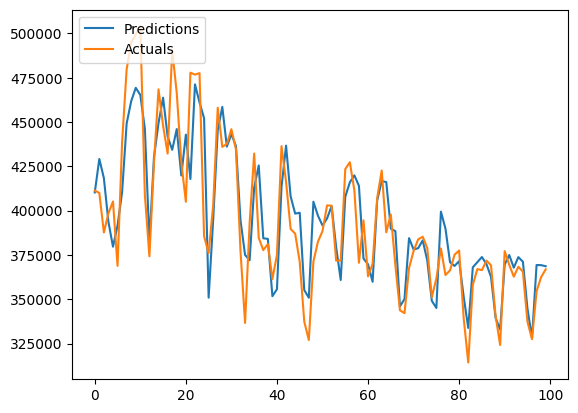

MAPE: 3.37%
RMSE: 17541.45
MAE : 12807.17


Predictions    Actuals
0    410261.06250  411339.27
1    429145.84375  409963.40
2    418361.50000  387672.63
3    393633.62500  398542.65
4    379642.62500  405159.36
..            ...        ...
353  363239.96875  360393.59
354  340982.87500  369325.03
355  356328.34375  371819.56
356  402259.84375  399427.25
357  404580.65625  408178.89

[358 rows x 2 columns]

In [199]:
predictions_plot(model19, X_test19, y_test19, 0, 100)

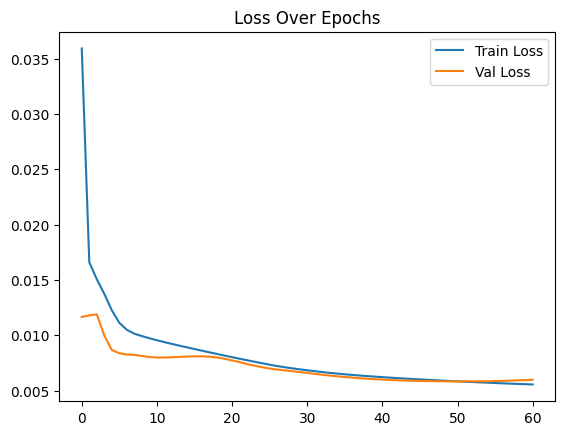

In [200]:
plt.plot(history19.history['loss'], label='Train Loss')
plt.plot(history19.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Switch to train/test only - compare Seasons & Seasons/Weekend ##

## Seasons & Weekday/Weekend - Train/Test ##

In [201]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data20 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train20, y_train20 = data20['train']
X_test20, y_test20 = data20['test']

i = X_train20.shape[1]
j = X_train20.shape[2]

In [202]:
model20 = Sequential()
model20.add(InputLayer((i, j)))
model20.add(LSTM(64))
model20.add(Dense(8, 'tanh'))
model20.add(Dense(1, 'linear'))

model20.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [203]:
cp20 = ModelCheckpoint('model20.keras', monitor='loss', save_best_only=True)
model20.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history20 = model20.fit(X_train20, y_train20, epochs=100, callbacks=[cp20])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0525 - root_mean_squared_error: 0.2235
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110 - root_mean_squared_error: 0.1051
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - root_mean_squared_error: 0.0919

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


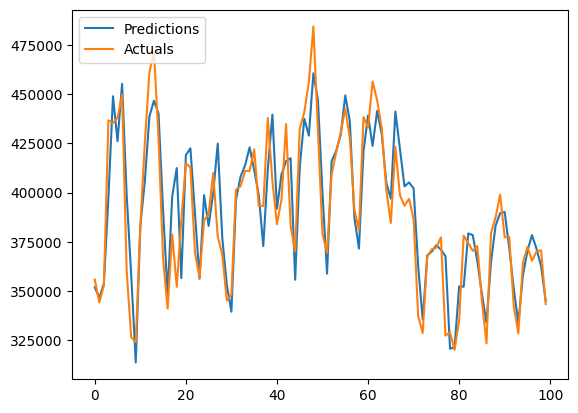

MAPE: 2.46%
RMSE: 13448.31
MAE : 9507.58


Predictions    Actuals
0     351902.09375  355814.96
1     346498.50000  344216.79
2     353848.15625  352812.68
3     397851.56250  436716.40
4     448901.50000  435360.14
...            ...        ...
1084  383439.34375  405457.46
1085  420971.40625  421027.63
1086  402788.71875  407376.71
1087  385448.56250  402263.51
1088  404373.12500  405023.08

[1089 rows x 2 columns]

In [204]:
model20 = load_model('model20.keras')

predictions_plot(model20, X_train20, y_train20, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


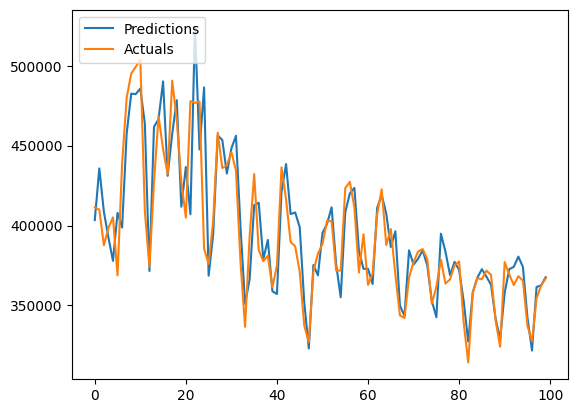

MAPE: 2.98%
RMSE: 16466.89
MAE : 11423.67


Predictions    Actuals
0    403439.81250  411339.27
1    435761.81250  409963.40
2    408650.59375  387672.63
3    392554.25000  398542.65
4    377904.34375  405159.36
..            ...        ...
353  362520.25000  360393.59
354  360364.87500  369325.03
355  388181.46875  371819.56
356  411223.59375  399427.25
357  389181.87500  408178.89

[358 rows x 2 columns]

In [205]:
predictions_plot(model20, X_test20, y_test20, 0, 100)

## Seasons Only - Train/Test ##

In [206]:
preprocessor = TimeSeriesPreprocessorTT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data21 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train21, y_train21 = data21['train']
X_test21, y_test21 = data21['test']

i = X_train21.shape[1]
j = X_train21.shape[2]

In [207]:
model21 = Sequential()
model21.add(InputLayer((i, j)))
model21.add(LSTM(64))
model21.add(Dense(8, 'tanh'))
model21.add(Dense(1, 'linear'))

model21.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [208]:
cp21 = ModelCheckpoint('model21.keras', monitor='loss', save_best_only=True)
model21.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history21 = model21.fit(X_train21, y_train21, epochs=100, callbacks=[cp21])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0549 - root_mean_squared_error: 0.2268
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0138 - root_mean_squared_error: 0.1175
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0127 - root_mean_squared_error: 0.1126
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - root_mean_squared_error: 0.1073

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


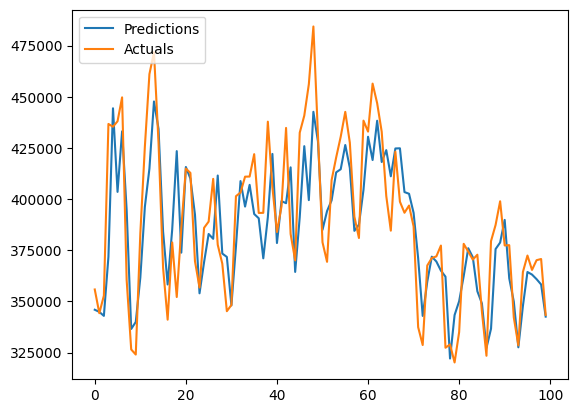

MAPE: 3.20%
RMSE: 16979.20
MAE : 12430.02


Predictions    Actuals
0     345905.56250  355814.96
1     344846.71875  344216.79
2     342909.78125  352812.68
3     371781.28125  436716.40
4     444372.09375  435360.14
...            ...        ...
1084  388077.06250  405457.46
1085  415844.40625  421027.63
1086  407367.28125  407376.71
1087  382791.62500  402263.51
1088  375385.78125  405023.08

[1089 rows x 2 columns]

In [209]:
model21 = load_model('model21.keras')
predictions_plot(model21, X_train21, y_train21, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


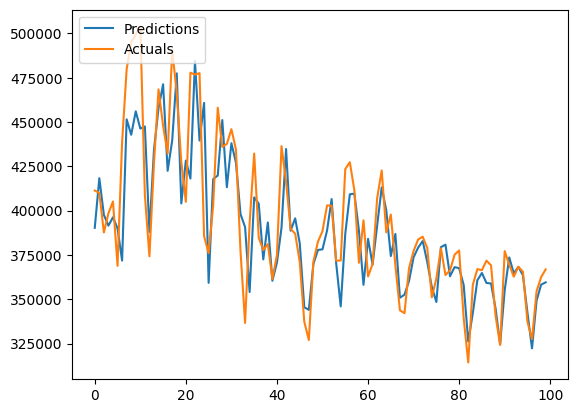

MAPE: 3.63%
RMSE: 18824.99
MAE : 13909.30


Predictions    Actuals
0    390322.31250  411339.27
1    418296.65625  409963.40
2    397601.21875  387672.63
3    391548.81250  398542.65
4    396270.46875  405159.36
..            ...        ...
353  381710.93750  360393.59
354  383927.06250  369325.03
355  390242.21875  371819.56
356  377719.28125  399427.25
357  370636.78125  408178.89

[358 rows x 2 columns]

In [210]:
predictions_plot(model21, X_test21, y_test21, 0, 100)

## Weekend/Weekday Only - Train/Test ##

In [211]:
preprocessor = TimeSeriesPreprocessorTT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data22 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train22, y_train22 = data22['train']
X_test22, y_test22 = data22['test']

i = X_train22.shape[1]
j = X_train22.shape[2]

In [212]:
model22 = Sequential()
model22.add(InputLayer((i, j)))
model22.add(LSTM(64))
model22.add(Dense(8, 'tanh'))
model22.add(Dense(1, 'linear'))

model22.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [213]:
cp22 = ModelCheckpoint('model22.keras', monitor='loss', save_best_only=True)
model22.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history22 = model22.fit(X_train22, y_train22, epochs=100, callbacks=[cp22])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0409 - root_mean_squared_error: 0.1984
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149 - root_mean_squared_error: 0.1219
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - root_mean_squared_error: 0.1027
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0976
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


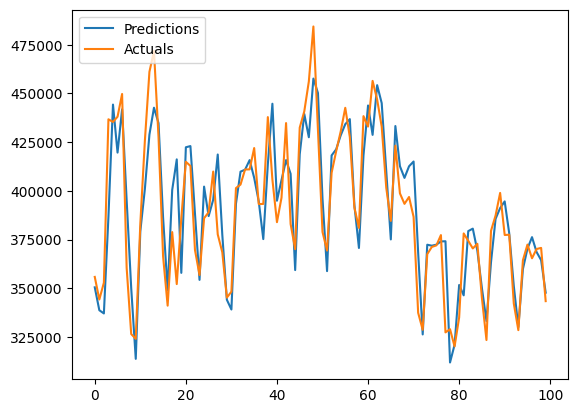

MAPE: 2.67%
RMSE: 14258.61
MAE : 10304.22


Predictions    Actuals
0     350467.81250  355814.96
1     338703.37500  344216.79
2     337053.78125  352812.68
3     386616.56250  436716.40
4     444265.87500  435360.14
...            ...        ...
1084  366762.15625  405457.46
1085  401107.56250  421027.63
1086  387038.06250  407376.71
1087  378882.21875  402263.51
1088  404565.87500  405023.08

[1089 rows x 2 columns]

In [214]:
model22 = load_model('model22.keras')

predictions_plot(model22, X_train22, y_train22, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


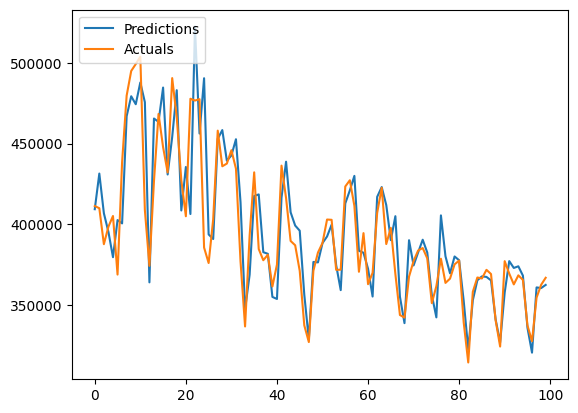

MAPE: 3.00%
RMSE: 16597.33
MAE : 11541.27


Predictions    Actuals
0    409355.81250  411339.27
1    431458.18750  409963.40
2    406856.59375  387672.63
3    395279.09375  398542.65
4    379618.37500  405159.36
..            ...        ...
353  351790.78125  360393.59
354  351207.06250  369325.03
355  371148.15625  371819.56
356  406002.03125  399427.25
357  391350.93750  408178.89

[358 rows x 2 columns]

In [215]:
predictions_plot(model22, X_test22, y_test22, 0, 100)

## Optuna Trials ##

In [ ]:
'''study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study.optimize(objective, n_trials=100)'''

"study = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy.optimize(objective, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial = study.best_trial

print(f"  MAE: {trial.value:.2f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")'''

'print("Best trial:")\ntrial = study.best_trial\n\nprint(f"  MAE: {trial.value:.2f}")\nprint("  Params:")\nfor key, value in trial.params.items():\n    print(f"    {key}: {value}")'

In [ ]:
'''study2 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study2.optimize(objective2, n_trials=100)'''

"study2 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy2.optimize(objective2, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial2 = study2.best_trial

print(f"  MAE: {trial2.value:.2f}")
print("  Params:")
for key, value in trial2.params.items():
    print(f"    {key}: {value}")'''

'print("Best trial:")\ntrial2 = study2.best_trial\n\nprint(f"  MAE: {trial2.value:.2f}")\nprint("  Params:")\nfor key, value in trial2.params.items():\n    print(f"    {key}: {value}")'

## Model 20 Re-Run (Post Optuna) ##

In [216]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data23 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train23, y_train23 = data23['train']
X_test23, y_test23 = data23['test']

i = X_train23.shape[1]
j = X_train23.shape[2]

In [217]:
model23 = Sequential()
model23.add(InputLayer((i, j)))
model23.add(LSTM(32, dropout=0.013))
model23.add(Dense(8, 'tanh'))
model23.add(Dense(1, 'linear'))

model23.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

In [218]:
cp23 = ModelCheckpoint('model23.keras', monitor='loss', save_best_only=True)
model23.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history23 = model23.fit(X_train23, y_train23, epochs=100, batch_size=8, callbacks=[cp23])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0701 - root_mean_squared_error: 0.2487
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0122 - root_mean_squared_error: 0.1102
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - root_mean_squared_error: 0.1039
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100 - root_mean_squared_error: 0.0997
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - root_mean_squared_error: 0.0966
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096 - root_mean_squared_error: 0.0977
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


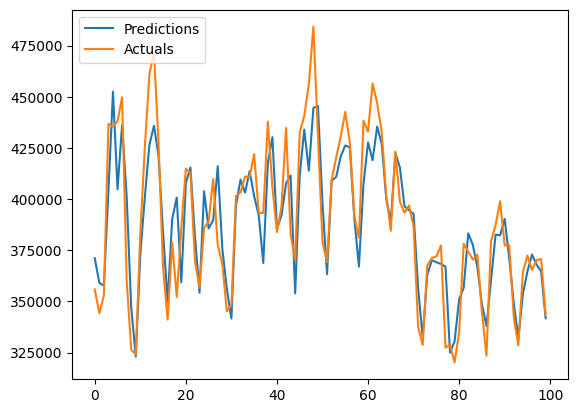

MAPE: 2.65%
RMSE: 14598.02
MAE : 10268.64


Predictions    Actuals
0     371103.31250  355814.96
1     359128.09375  344216.79
2     357626.71875  352812.68
3     403906.59375  436716.40
4     452526.12500  435360.14
...            ...        ...
1084  395198.59375  405457.46
1085  416138.37500  421027.63
1086  400625.75000  407376.71
1087  385901.75000  402263.51
1088  419801.65625  405023.08

[1089 rows x 2 columns]

In [219]:
model23 = load_model('model23.keras')

predictions_plot(model23, X_train23, y_train23, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


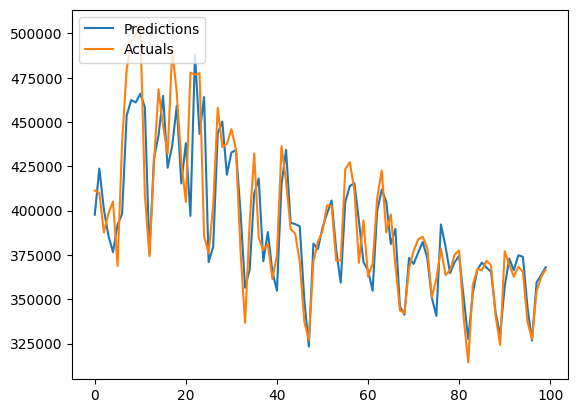

MAPE: 2.99%
RMSE: 16449.68
MAE : 11445.23


Predictions    Actuals
0    397677.90625  411339.27
1    423741.68750  409963.40
2    400659.56250  387672.63
3    385874.37500  398542.65
4    376614.56250  405159.36
..            ...        ...
353  377632.87500  360393.59
354  371542.78125  369325.03
355  387083.71875  371819.56
356  415132.87500  399427.25
357  408084.12500  408178.89

[358 rows x 2 columns]

In [220]:
predictions_plot(model23, X_test23, y_test23, 0, 100)

## Model 20 Re-Run (Post Optuna Trial 2) ##

In [221]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data24 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train24, y_train24 = data24['train']
X_test24, y_test24 = data24['test']

i = X_train24.shape[1]
j = X_train24.shape[2]

In [222]:
model24 = Sequential()
model24.add(InputLayer((i, j)))
model24.add(LSTM(57, dropout=0.013))
model24.add(Dense(8, 'tanh'))
model24.add(Dense(1, 'linear'))

model24.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 57)             │        16,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 8)              │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,661 (65.08 KB)

 Trainable params: 16,661 (65.08 KB)

 Non-trainable params: 0 (0.00 B)

In [223]:
cp24 = ModelCheckpoint('model24.keras', monitor='loss', save_best_only=True)
model24.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0012, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history24 = model24.fit(X_train24, y_train24, epochs=100, batch_size=32, callbacks=[cp24])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0459 - root_mean_squared_error: 0.2099
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - root_mean_squared_error: 0.1053
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 - root_mean_squared_error: 0.1014
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - root_mean_squared_error: 0.0968
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - root_mean_squared_error: 0.0951
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 - root_mean_squared_error: 0.0908

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


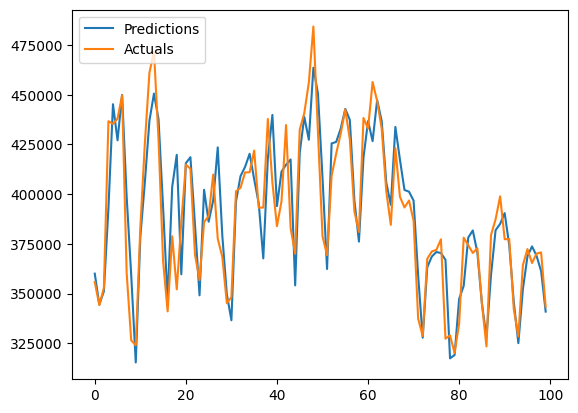

MAPE: 2.47%
RMSE: 13447.14
MAE : 9530.84


Predictions    Actuals
0     360030.90625  355814.96
1     344443.18750  344216.79
2     351156.28125  352812.68
3     392918.78125  436716.40
4     445253.03125  435360.14
...            ...        ...
1084  394299.40625  405457.46
1085  421649.84375  421027.63
1086  402449.62500  407376.71
1087  388457.25000  402263.51
1088  404288.59375  405023.08

[1089 rows x 2 columns]

In [225]:
model24 = load_model('model24.keras')

predictions_plot(model24, X_train24, y_train24, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


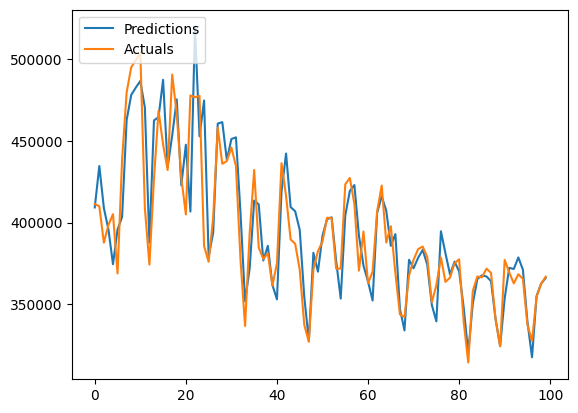

MAPE: 2.94%
RMSE: 16101.42
MAE : 11266.74


Predictions    Actuals
0    409261.46875  411339.27
1    434650.71875  409963.40
2    408869.71875  387672.63
3    395763.90625  398542.65
4    374518.81250  405159.36
..            ...        ...
353  369351.81250  360393.59
354  369988.21875  369325.03
355  388864.53125  371819.56
356  414723.59375  399427.25
357  411148.18750  408178.89

[358 rows x 2 columns]

In [226]:
predictions_plot(model24, X_test24, y_test24, 0, 100)

## Model 20 Re-Run (Post Optuna) - Batch Size Adjust ##

In [227]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data25 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train25, y_train25 = data25['train']
X_test25, y_test25 = data25['test']

i = X_train25.shape[1]
j = X_train25.shape[2]

In [228]:
model25 = Sequential()
model25.add(InputLayer((i, j)))
model25.add(LSTM(32, dropout=0.013))
model25.add(Dense(8, 'tanh'))
model25.add(Dense(1, 'linear'))

model25.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

In [229]:
cp25 = ModelCheckpoint('model25.keras', monitor='loss', save_best_only=True)
model25.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history25 = model25.fit(X_train25, y_train25, epochs=100, batch_size=4, callbacks=[cp25])

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0222 - root_mean_squared_error: 0.1448
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - root_mean_squared_error: 0.1032
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101 - root_mean_squared_error: 0.1002
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096 - root_mean_squared_error: 0.0979
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925
Epoch 9/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925
Epoch 10/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0081 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


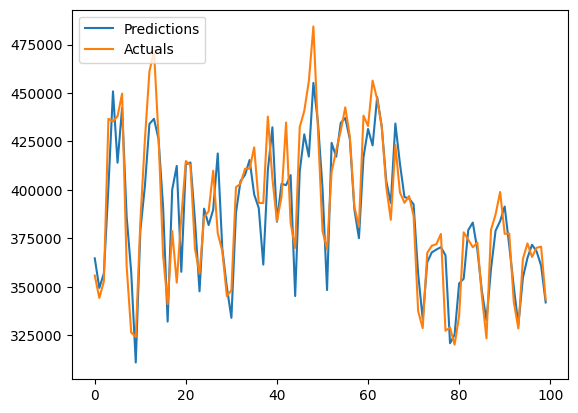

MAPE: 2.48%
RMSE: 13537.44
MAE : 9653.86


Predictions    Actuals
0     364687.18750  355814.96
1     349409.56250  344216.79
2     356931.12500  352812.68
3     401483.06250  436716.40
4     450865.18750  435360.14
...            ...        ...
1084  387738.25000  405457.46
1085  421086.75000  421027.63
1086  400150.12500  407376.71
1087  384448.43750  402263.51
1088  406371.71875  405023.08

[1089 rows x 2 columns]

In [230]:
model25 = load_model('model25.keras')

predictions_plot(model25, X_train25, y_train25, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


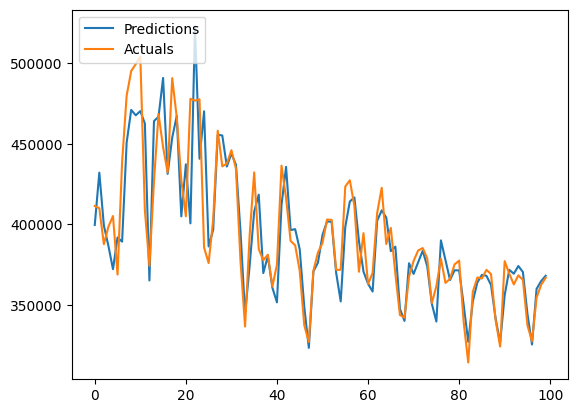

MAPE: 2.84%
RMSE: 16023.58
MAE : 10976.86


Predictions    Actuals
0    399637.62500  411339.27
1    432043.37500  409963.40
2    399242.81250  387672.63
3    386595.87500  398542.65
4    372199.93750  405159.36
..            ...        ...
353  363632.37500  360393.59
354  370656.37500  369325.03
355  386660.00000  371819.56
356  411635.53125  399427.25
357  405933.68750  408178.89

[358 rows x 2 columns]

In [231]:
predictions_plot(model25, X_test25, y_test25, 0, 100)

## Stacked LSTM - From Model 23 ##

In [232]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data26 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train26, y_train26 = data26['train']
X_test26, y_test26 = data26['test']

i = X_train26.shape[1]
j = X_train26.shape[2]

In [233]:
model26 = Sequential()
model26.add(InputLayer((i, j)))
model26.add(LSTM(32, dropout=0.013, return_sequences=True))
model26.add(LSTM(16, dropout=0.013))
model26.add(Dense(8, 'tanh'))
model26.add(Dense(1, 'linear'))

model26.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 7, 32)          │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,169 (35.82 KB)

 Trainable params: 9,169 (35.82 KB)

 Non-trainable params: 0 (0.00 B)

In [234]:
cp26 = ModelCheckpoint('model26.keras', monitor='loss', save_best_only=True)
model26.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history26 = model26.fit(X_train26, y_train26, epochs=100, batch_size=8, callbacks=[cp26])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0419 - root_mean_squared_error: 0.1965
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0163 - root_mean_squared_error: 0.1273
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0151 - root_mean_squared_error: 0.1224
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0134 - root_mean_squared_error: 0.1157
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0124 - root_mean_squared_error: 0.1111
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0115 - root_mean_squared_error: 0.1070
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1078
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0109 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


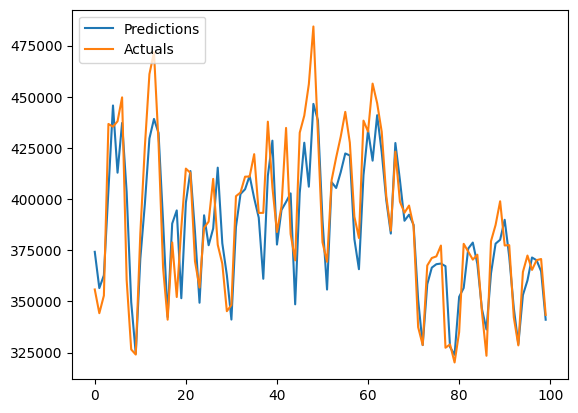

MAPE: 2.65%
RMSE: 14524.79
MAE : 10365.68


Predictions    Actuals
0     374216.12500  355814.96
1     356482.28125  344216.79
2     362736.46875  352812.68
3     404306.62500  436716.40
4     445745.12500  435360.14
...            ...        ...
1084  398179.75000  405457.46
1085  428657.43750  421027.63
1086  415936.18750  407376.71
1087  396077.15625  402263.51
1088  411768.87500  405023.08

[1089 rows x 2 columns]

In [235]:
model26 = load_model('model26.keras')

predictions_plot(model26, X_train26, y_train26, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


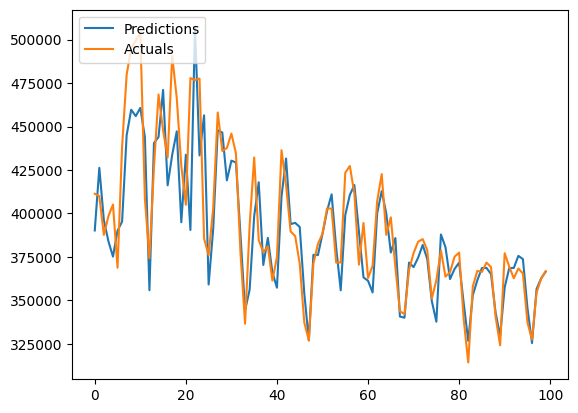

MAPE: 3.10%
RMSE: 17115.04
MAE : 11992.05


Predictions    Actuals
0    390229.15625  411339.27
1    426247.50000  409963.40
2    396105.03125  387672.63
3    384004.00000  398542.65
4    375216.15625  405159.36
..            ...        ...
353  373860.93750  360393.59
354  378369.46875  369325.03
355  398682.43750  371819.56
356  417240.34375  399427.25
357  407662.46875  408178.89

[358 rows x 2 columns]

In [236]:
predictions_plot(model26, X_test26, y_test26, 0, 100)

## CNN-LSTM Test - From Model 23 ##

In [237]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data27 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train27, y_train27 = data27['train']
X_test27, y_test27 = data27['test']

i = X_train27.shape[1]
j = X_train27.shape[2]

In [238]:
model27 = Sequential()
model27.add(InputLayer((i, j)))
model27.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model27.add(MaxPooling1D(pool_size=2))
model27.add(Dropout(0.013))
model27.add(LSTM(32, dropout=0.013))
model27.add(Dense(8, 'tanh'))
model27.add(Dense(1, 'linear'))

model27.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 64)          │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,249 (59.57 KB)

 Trainable params: 15,249 (59.57 KB)

 Non-trainable params: 0 (0.00 B)

In [239]:
cp27 = ModelCheckpoint('model27.keras', monitor='loss', save_best_only=True)
model27.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history27 = model27.fit(X_train27, y_train27, epochs=100, batch_size=8, callbacks=[cp27])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0597 - root_mean_squared_error: 0.2310
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0117 - root_mean_squared_error: 0.1078
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112 - root_mean_squared_error: 0.1056
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - root_mean_squared_error: 0.1049
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - root_mean_squared_error: 0.1044
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0107 - root_mean_squared_error: 0.1032
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


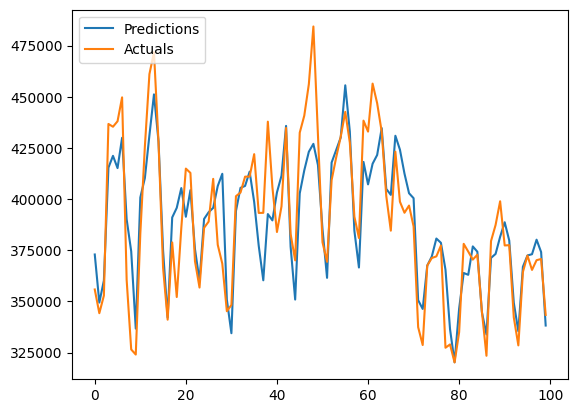

MAPE: 2.86%
RMSE: 14976.26
MAE : 10985.87


Predictions    Actuals
0     372916.21875  355814.96
1     349417.03125  344216.79
2     360188.06250  352812.68
3     415358.62500  436716.40
4     421125.71875  435360.14
...            ...        ...
1084  421956.56250  405457.46
1085  417373.09375  421027.63
1086  395769.21875  407376.71
1087  387228.40625  402263.51
1088  387895.46875  405023.08

[1089 rows x 2 columns]

In [240]:
model27 = load_model('model27.keras')

predictions_plot(model27, X_train27, y_train27, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


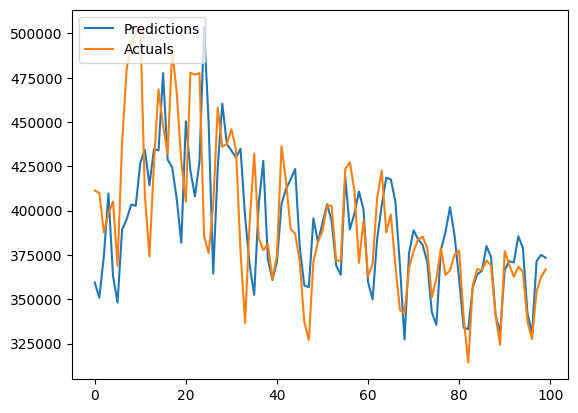

MAPE: 4.92%
RMSE: 26142.55
MAE : 18920.29


Predictions    Actuals
0    359444.12500  411339.27
1    350882.34375  409963.40
2    374463.03125  387672.63
3    409633.65625  398542.65
4    363359.50000  405159.36
..            ...        ...
353  386889.53125  360393.59
354  368802.12500  369325.03
355  383400.50000  371819.56
356  399178.96875  399427.25
357  400251.56250  408178.89

[358 rows x 2 columns]

In [241]:
predictions_plot(model27, X_test27, y_test27, 0, 100)

## CNN-LSTM Optuna Trials ##

In [ ]:
'''study3 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study3.optimize(objective3, n_trials=100)'''

"study3 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy3.optimize(objective3, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial3 = study3.best_trial

print(f"  MAE: {trial3.value:.2f}")
print("  Params:")
for key, value in trial3.params.items():
    print(f"    {key}: {value}")'''

'print("Best trial:")\ntrial3 = study3.best_trial\n\nprint(f"  MAE: {trial3.value:.2f}")\nprint("  Params:")\nfor key, value in trial3.params.items():\n    print(f"    {key}: {value}")'

## Explore Temp^2 ##

In [242]:
seasonsWdWeDemandDF2 = seasonsWdWeDemandDF.copy()
seasonsWdWeDemandDF2['temp2'] = seasonsWdWeDemandDF2['avg_temp']**2
seasonsWdWeDemandDF2.head()


is_weekend  is_weekday  is_winter  is_spring  is_summer  \
datetime_au                                                            
2016-01-01            0           1          0          0          1   
2016-01-02            1           0          0          0          1   
2016-01-03            1           0          0          0          1   
2016-01-04            0           1          0          0          1   
2016-01-05            0           1          0          0          1   

             is_autumn  sum_30_min_demand   avg_temp  min_temp  max_temp  \
datetime_au                                                                
2016-01-01           0          329352.88  20.704082      15.2      26.0   
2016-01-02           0          323133.95  20.572917      14.9      24.2   
2016-01-03           0          317665.92  21.130769      19.0      22.9   
2016-01-04           0          353210.40  20.144444      18.4      23.1   
2016-01-05           0          358082.97  18.904808      17.4      20.3   

             hd_next_24h  cd_next_24h  temp_range       temp2  
datetime_au                                                    
2016-01-01           0.0     1.204082        10.8  428.658996  
2016-01-02           0.0     1.072917         9.3  423.244900  
2016-01-03           0.0     1.630769         3.9  446.509408  
2016-01-04           0.0     0.644444         4.7  405.798642  
2016-01-05           0.0     0.000000         2.9  357.391754

In [243]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data28 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train28, y_train28 = data28['train']
X_test28, y_test28 = data28['test']

i = X_train28.shape[1]
j = X_train28.shape[2]

In [244]:
model28 = Sequential()
model28.add(InputLayer((i, j)))
model28.add(LSTM(32, dropout=0.013))
model28.add(Dense(8, 'tanh'))
model28.add(Dense(1, 'linear'))

model28.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                  │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289 (24.57 KB)

 Trainable params: 6,289 (24.57 KB)

 Non-trainable params: 0 (0.00 B)

In [245]:
cp28 = ModelCheckpoint('model28.keras', monitor='loss', save_best_only=True)
model28.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history28 = model28.fit(X_train28, y_train28, epochs=100, batch_size=8, callbacks=[cp28])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1639 - root_mean_squared_error: 0.3802
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139 - root_mean_squared_error: 0.1174
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0129 - root_mean_squared_error: 0.1129
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - root_mean_squared_error: 0.1069
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0103 - root_mean_squared_error: 0.1014
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100 - root_mean_squared_error: 0.0996
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


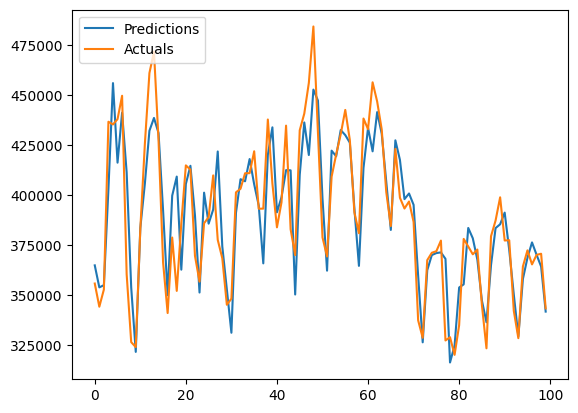

MAPE: 2.59%
RMSE: 14236.88
MAE : 9982.58


Predictions    Actuals
0     364899.12500  355814.96
1     353882.06250  344216.79
2     354998.68750  352812.68
3     403113.87500  436716.40
4     456041.62500  435360.14
...            ...        ...
1084  394066.12500  405457.46
1085  423594.37500  421027.63
1086  411352.56250  407376.71
1087  383895.71875  402263.51
1088  413258.87500  405023.08

[1089 rows x 2 columns]

In [246]:
model28 = load_model('model28.keras')

predictions_plot(model28, X_train28, y_train28, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


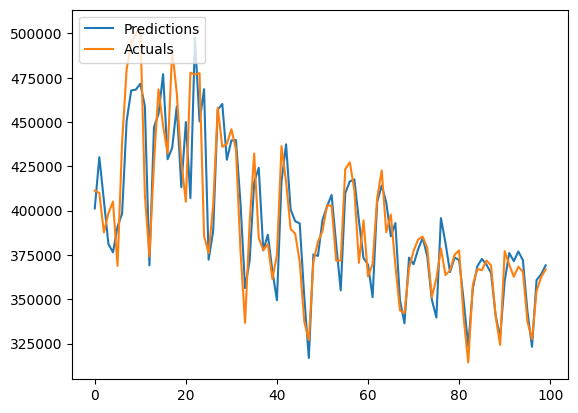

MAPE: 3.02%
RMSE: 16046.73
MAE : 11534.22


Predictions    Actuals
0    401253.25000  411339.27
1    430151.81250  409963.40
2    405815.15625  387672.63
3    381147.06250  398542.65
4    376450.56250  405159.36
..            ...        ...
353  366826.78125  360393.59
354  371499.00000  369325.03
355  389607.40625  371819.56
356  419704.71875  399427.25
357  412140.78125  408178.89

[358 rows x 2 columns]

In [247]:
predictions_plot(model28, X_test28, y_test28, 0, 100)

## Explore Recurrent Dropout ##

In [248]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data29 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train29, y_train29 = data29['train']
X_test29, y_test29 = data29['test']

i = X_train29.shape[1]
j = X_train29.shape[2]

In [249]:
model29 = Sequential()
model29.add(InputLayer((i, j)))
model29.add(LSTM(32, dropout=0.013, recurrent_dropout=0.013))
model29.add(Dense(8, 'tanh'))
model29.add(Dense(1, 'linear'))

model29.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289 (24.57 KB)

 Trainable params: 6,289 (24.57 KB)

 Non-trainable params: 0 (0.00 B)

In [250]:
cp29 = ModelCheckpoint('model29.keras', monitor='loss', save_best_only=True)
model29.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history29 = model29.fit(X_train29, y_train29, epochs=100, batch_size=8, callbacks=[cp29])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1391 - root_mean_squared_error: 0.3491
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0145 - root_mean_squared_error: 0.1201
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0112 - root_mean_squared_error: 0.1058
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0105 - root_mean_squared_error: 0.1020
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0100 - root_mean_squared_error: 0.0999
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0096 - root_mean_squared_error: 0.0979
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0088 - r

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


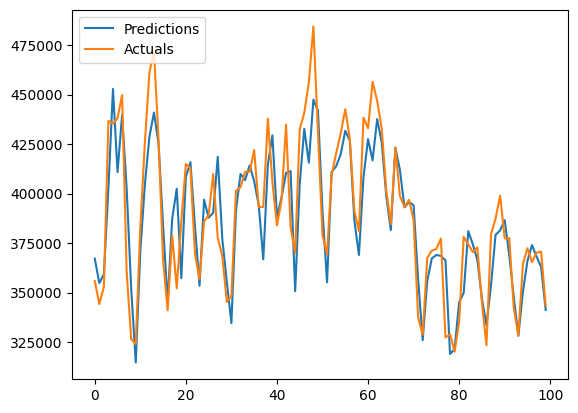

MAPE: 2.66%
RMSE: 14639.16
MAE : 10381.04


Predictions    Actuals
0     367120.84375  355814.96
1     354841.71875  344216.79
2     359125.34375  352812.68
3     403018.84375  436716.40
4     452831.59375  435360.14
...            ...        ...
1084  388926.65625  405457.46
1085  420150.46875  421027.63
1086  405207.65625  407376.71
1087  385102.93750  402263.51
1088  417062.15625  405023.08

[1089 rows x 2 columns]

In [251]:
model29 = load_model('model29.keras')

predictions_plot(model29, X_train29, y_train29, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


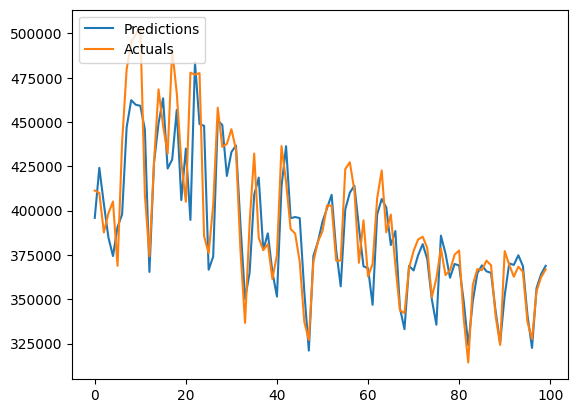

MAPE: 2.96%
RMSE: 16055.85
MAE : 11439.99


Predictions    Actuals
0    395913.37500  411339.27
1    424146.12500  409963.40
2    403729.12500  387672.63
3    384851.90625  398542.65
4    374384.28125  405159.36
..            ...        ...
353  367350.06250  360393.59
354  363170.18750  369325.03
355  383540.21875  371819.56
356  413975.50000  399427.25
357  403432.56250  408178.89

[358 rows x 2 columns]

In [252]:
predictions_plot(model29, X_test29, y_test29, 0, 100)

## Recurrent Optuna Trial w/ temp^2 ##

In [ ]:
'''study4 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study4.optimize(objective4, n_trials=100)'''

"study4 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy4.optimize(objective4, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial3 = study4.best_trial

print(f"  MAE: {trial4.value:.2f}")
print("  Params:")
for key, value in trial4.params.items():
    print(f"    {key}: {value}")'''

## Temp^2/Recurrent Dropout (Post Optuna) ##

In [253]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data30 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train30, y_train30 = data30['train']
X_test30, y_test30 = data30['test']

i = X_train30.shape[1]
j = X_train30.shape[2]

In [254]:
model30 = Sequential()
model30.add(InputLayer((i, j)))
model30.add(LSTM(64, dropout=0.00145, recurrent_dropout=0.3))
model30.add(Dense(8, 'tanh'))
model30.add(Dense(1, 'linear'))

model30.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

In [255]:
cp30 = ModelCheckpoint('model30.keras', monitor='loss', save_best_only=True)
model30.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00311, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history30 = model30.fit(X_train30, y_train30, epochs=100, batch_size=32, callbacks=[cp30])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0669 - root_mean_squared_error: 0.2480
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0148 - root_mean_squared_error: 0.1216
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0110 - root_mean_squared_error: 0.1051
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0090 - root_mean_squared_error: 0.0951
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0086 - root_mean_squared_error: 0.0930
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0079 - root_mean_squared_err

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


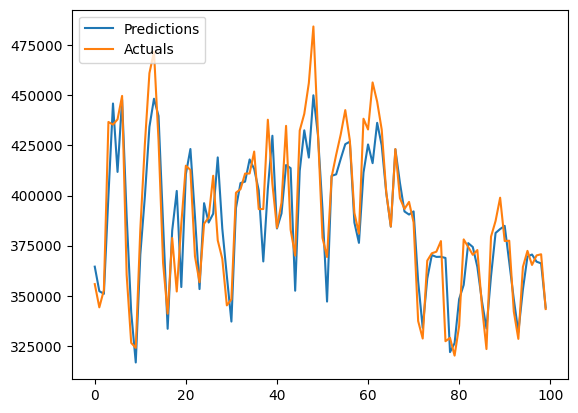

MAPE: 2.47%
RMSE: 13395.33
MAE : 9595.05


Predictions    Actuals
0     364522.09375  355814.96
1     352292.03125  344216.79
2     350958.09375  352812.68
3     399974.34375  436716.40
4     445923.65625  435360.14
...            ...        ...
1084  381620.21875  405457.46
1085  420070.81250  421027.63
1086  402630.09375  407376.71
1087  376705.53125  402263.51
1088  393806.46875  405023.08

[1089 rows x 2 columns]

In [256]:
model30 = load_model('model30.keras')

predictions_plot(model30, X_train30, y_train30, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


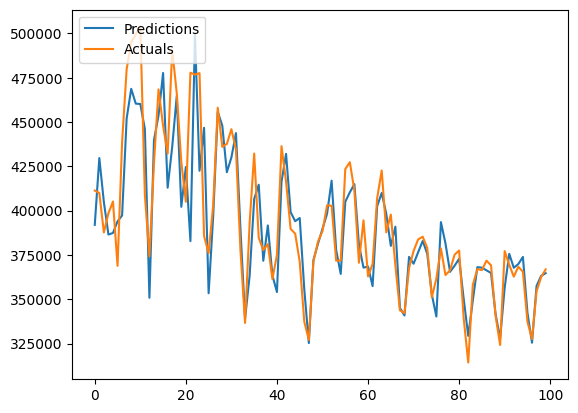

MAPE: 2.80%
RMSE: 15839.30
MAE : 10844.45


Predictions    Actuals
0    391975.03125  411339.27
1    429669.37500  409963.40
2    404776.21875  387672.63
3    386504.03125  398542.65
4    387401.43750  405159.36
..            ...        ...
353  367937.12500  360393.59
354  358520.37500  369325.03
355  374103.53125  371819.56
356  402841.65625  399427.25
357  390907.25000  408178.89

[358 rows x 2 columns]

In [257]:
predictions_plot(model30, X_test30, y_test30, 0, 100)

## Test Attention ##

In [258]:
@register_keras_serializable(package="Custom")
class SimpleAttention(Layer):
    def __init__(self, return_attention=False, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(SimpleAttention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)  # attention weights
        context = tf.reduce_sum(x * a, axis=1)
        if self.return_attention:
            return [context, a]   # return both if requested
        return context

    def get_config(self):
        config = super(SimpleAttention, self).get_config()
        config.update({"return_attention": self.return_attention})
        return config

In [266]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data31 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train31, y_train31 = data31['train']
X_test31, y_test31 = data31['test']

i = X_train31.shape[1]
j = X_train31.shape[2]

In [267]:
inputs = Input(shape=(i, j))  # i = window_size, j = features
lstm_out = LSTM(64, return_sequences=True,
                dropout=0.00145, recurrent_dropout=0.3, name='LSTM')(inputs)

context, att_weights = SimpleAttention(return_attention=True)(lstm_out)
dense = Dense(8, activation='tanh')(context)
outputs = Dense(1, activation='linear')(dense)

model31 = Model(inputs, outputs)

In [268]:
cp31 = ModelCheckpoint('model31.keras', monitor='loss', save_best_only=True)
model31.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00311, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history31 = model31.fit(X_train31, y_train31, epochs=100, batch_size=32, callbacks=[cp31])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0545 - root_mean_squared_error: 0.2254
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0116 - root_mean_squared_err

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


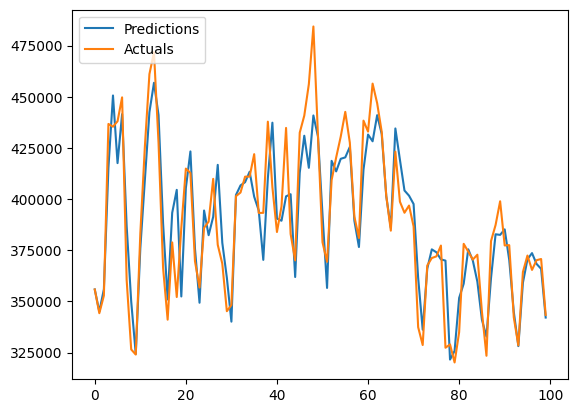

MAPE: 2.42%
RMSE: 13163.33
MAE : 9316.42


Predictions    Actuals
0     355823.00000  355814.96
1     345011.31250  344216.79
2     355939.40625  352812.68
3     415319.62500  436716.40
4     450633.90625  435360.14
...            ...        ...
1084  394079.18750  405457.46
1085  424221.34375  421027.63
1086  414093.03125  407376.71
1087  396623.75000  402263.51
1088  416683.68750  405023.08

[1089 rows x 2 columns]

In [269]:
model31 = load_model('model31.keras')

predictions_plot(model31, X_train31, y_train31, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


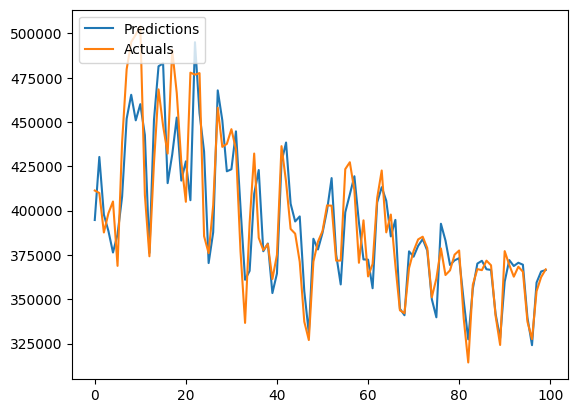

MAPE: 3.00%
RMSE: 16116.24
MAE : 11578.61


Predictions    Actuals
0    394714.34375  411339.27
1    430283.65625  409963.40
2    397755.96875  387672.63
3    388500.21875  398542.65
4    376377.06250  405159.36
..            ...        ...
353  369902.53125  360393.59
354  359656.96875  369325.03
355  391950.84375  371819.56
356  424909.87500  399427.25
357  394825.93750  408178.89

[358 rows x 2 columns]

In [270]:
predictions_plot(model31, X_test31, y_test31, 0, 100)